# Penalty Comparison: fidelity vs sensitivity as a function of λ (sensitivity weight)

This notebook compares the effectiveness of the toggling-frame robustness objective for both multiplicative and additive errors. It's strucuted as follows:
* Imports
* Problem Setups: Here we compare the effect of the toggling frame robustness objective on additive and multiplicative errors without any variational states.
    * Base case: unitary smooth pulse problem w/o any robustness or sentivity objectives
    * Toggle Robustness: Optimize pulses for toggle-frame robustness
* Plot Fidelity vs. Error
* Plot Trajectories and Control pulses
* Pareto Frontiers of Fidelity vs. Robustness Penality

## Imports

In [26]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
Pkg.develop(path="../../QuantumCollocation.jl")
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using Statistics
using CairoMakie
using NamedTrajectories
using TrajectoryIndexingUtils
using Random

## Problem Setups
Here, we first setup the quantum systems and solve for optimal pulses. There is the default smooth unitary pulse case and the toggle-fram robustness subject to three error models (additive error, mujltiplcative error, both).

#### Preliminary Variables

In [27]:
# Problem parameters
T = 20
Δt = 0.5
U_goal = GATES.X
H_drive = [PAULIS.X, PAULIS.Y]
rob_scale = 1 / 8.0
piccolo_opts = PiccoloOptions(verbose=false)
da_bound=Inf
sys = QuantumSystem(H_drive)



QuantumSystem: levels = 2, n_drives = 2

Toggle setup

In [28]:
n_drives = sys.n_drives
n_guesses = 1
a_guess = [randn(2, T) for _ in 1:n_guesses]
a_bounds = fill(1/Δt, n_drives)
da_bounds = fill(1.0, n_drives)
dda_bounds = fill(1.0, n_drives)
control_bounds = (a_bounds, da_bounds, dda_bounds)
def_seeds = []
add_seeds = []
mult_seeds = []
both_seeds = []


for i in 1:n_guesses
    def_traj = initialize_trajectory(
                    U_goal,
                    T,
                    Δt,
                    n_drives,
                    control_bounds;
                    a_guess=deepcopy(a_guess[i]),
                    system=sys
                )
    push!(def_seeds, def_traj)

    add_traj = initialize_trajectory(
                    U_goal,
                    T,
                    Δt,
                    n_drives,
                    control_bounds;
                    a_guess=deepcopy(a_guess[i]),
                    system=sys
                )

    push!(add_seeds, add_traj)

    mult_traj = initialize_trajectory(
                U_goal,
                T,
                Δt,
                n_drives,
                control_bounds;
                a_guess=deepcopy(a_guess[i]),
                system=sys
            )

    push!(mult_seeds, mult_traj)

    both_traj = initialize_trajectory(
                U_goal,
                T,
                Δt,
                n_drives,
                control_bounds;
                a_guess=deepcopy(a_guess[i]),
                system=sys
            )
            
    push!(both_seeds, both_traj)
end

Run all seeds for various weights (lambdas) using the toggle objective on only the additive error problem

In [34]:
sweep_rob_loss_λ = [λ for λ in 1.0:15:230.0]
n_seeds = n_guesses
n_lambdas = length(sweep_rob_loss_λ)
add_probs = Matrix{Any}(undef, n_seeds, n_lambdas)
Hₑ_add = a -> PAULIS.X

for i in 1:n_seeds
    for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
        
        # Add problem
        add_prob = UnitarySmoothPulseProblem(
            sys, U_goal, T, Δt;
            init_trajectory=deepcopy(add_seeds[i]),
            piccolo_options=piccolo_opts,
            activate_rob_loss=true,
            H_err=Hₑ_add,
            Q_t=λ
        )
        solve!(add_prob; max_iter=250, print_level=5)
        add_probs[i, λ_idx] = add_prob
    end
end

Plot the corresponding fidelity as a function of epsilon (error magnitude)

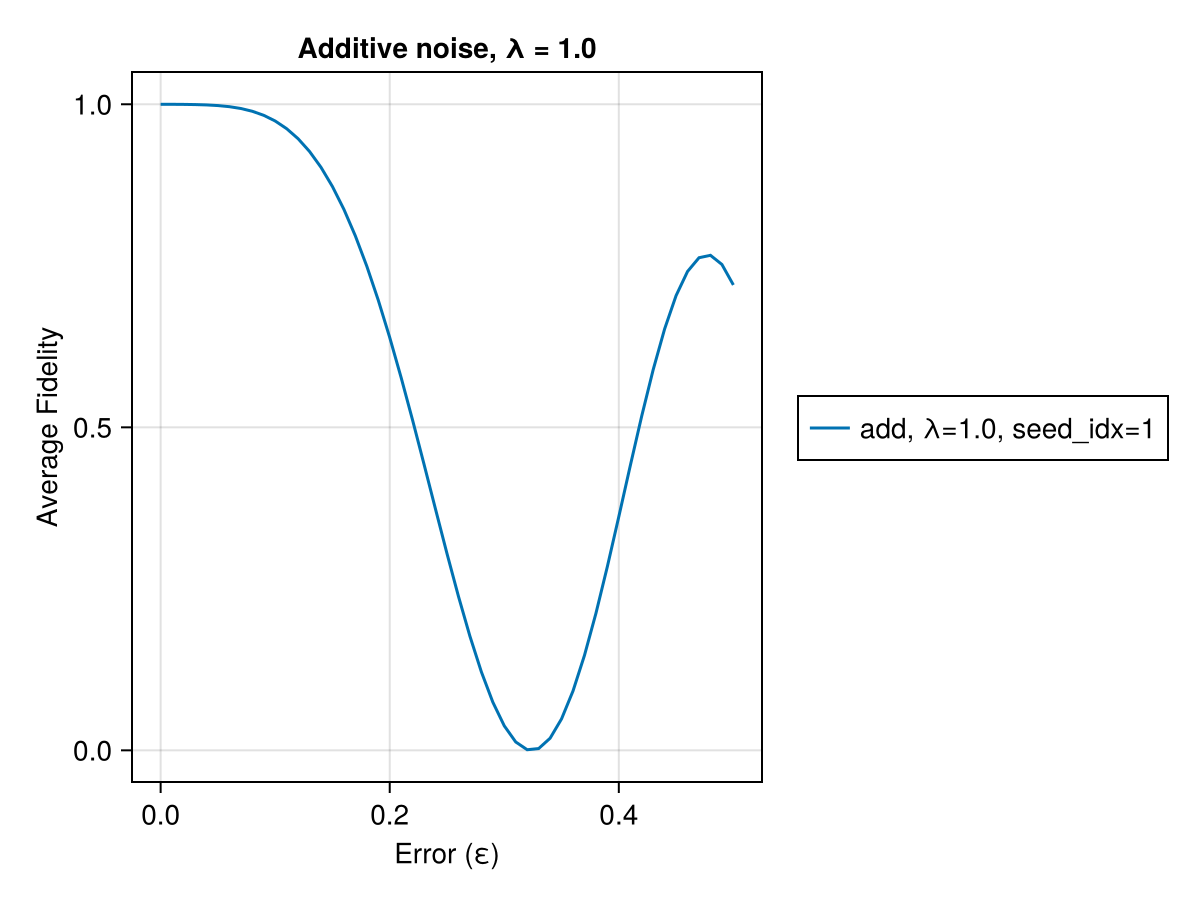

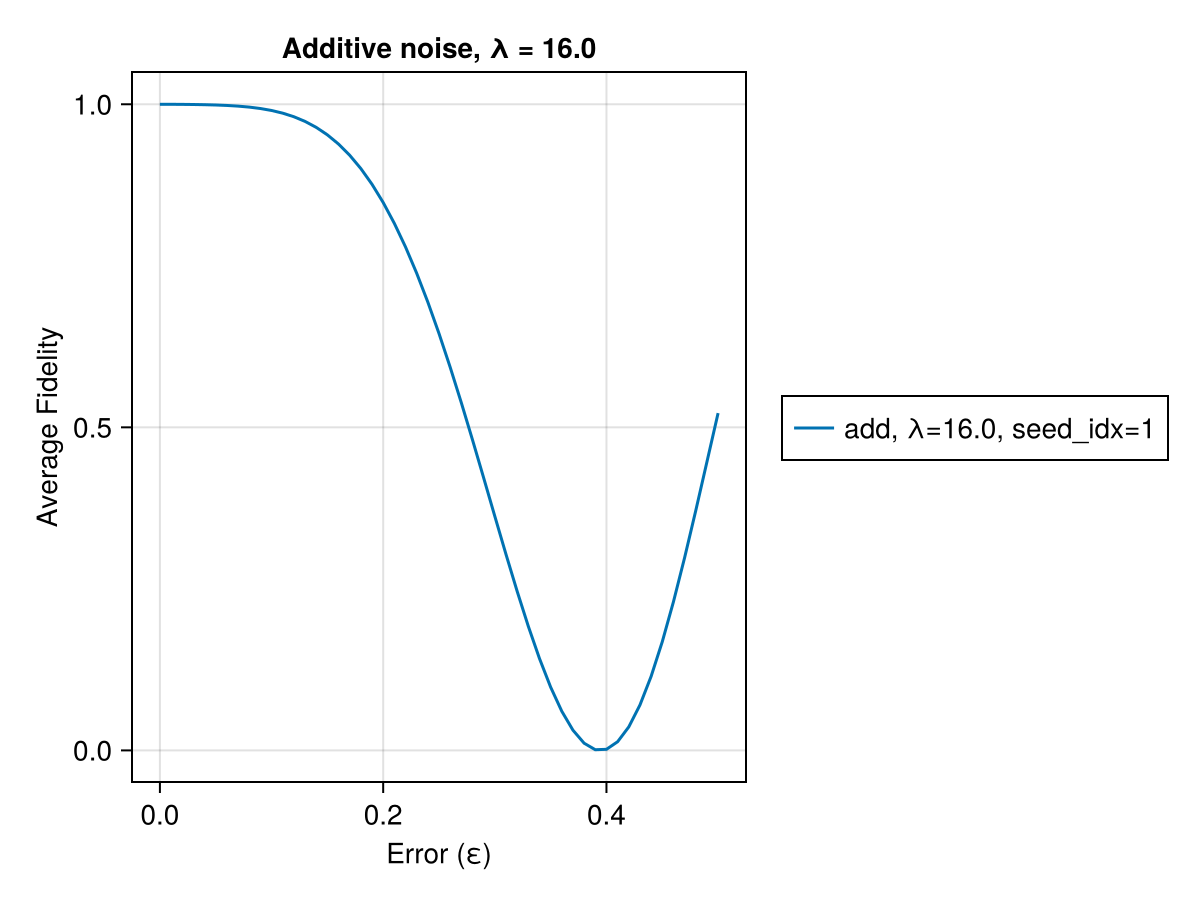

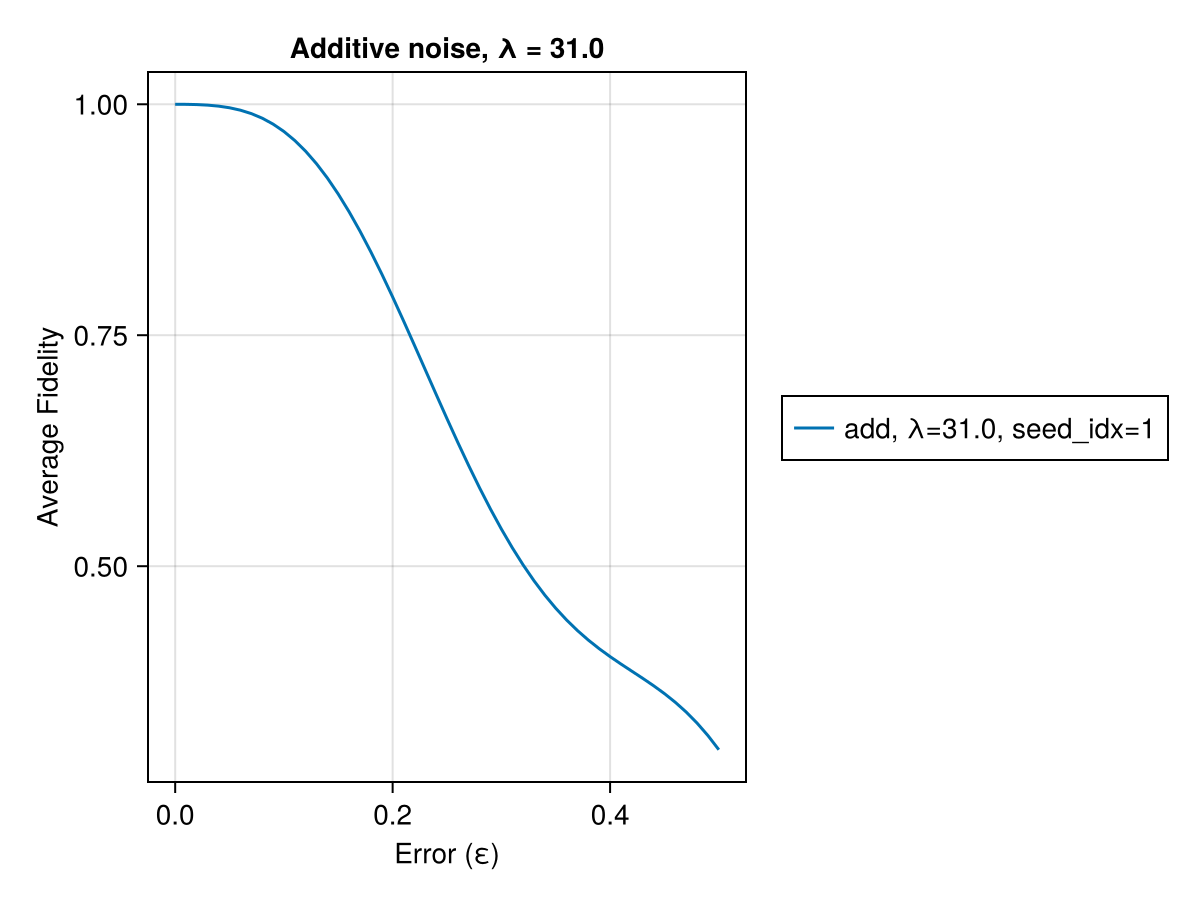

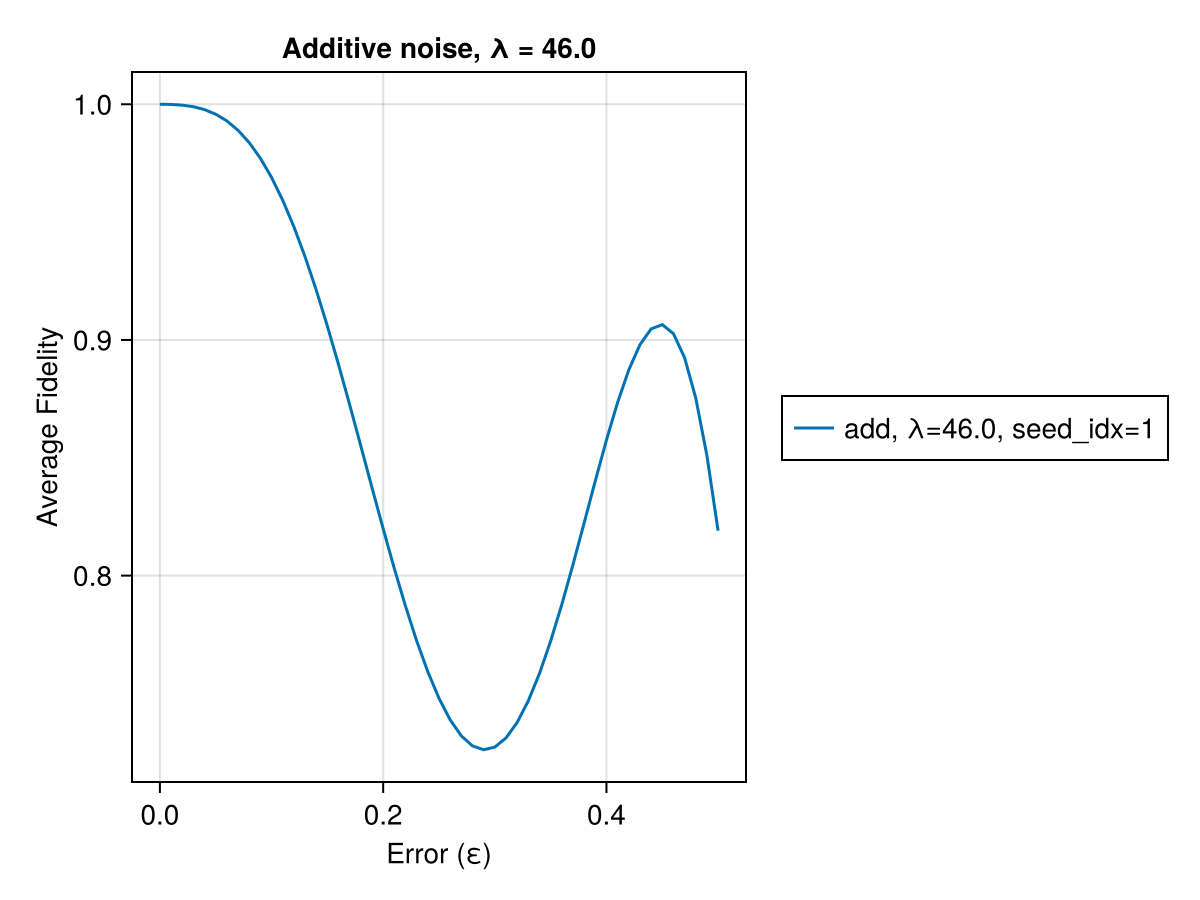

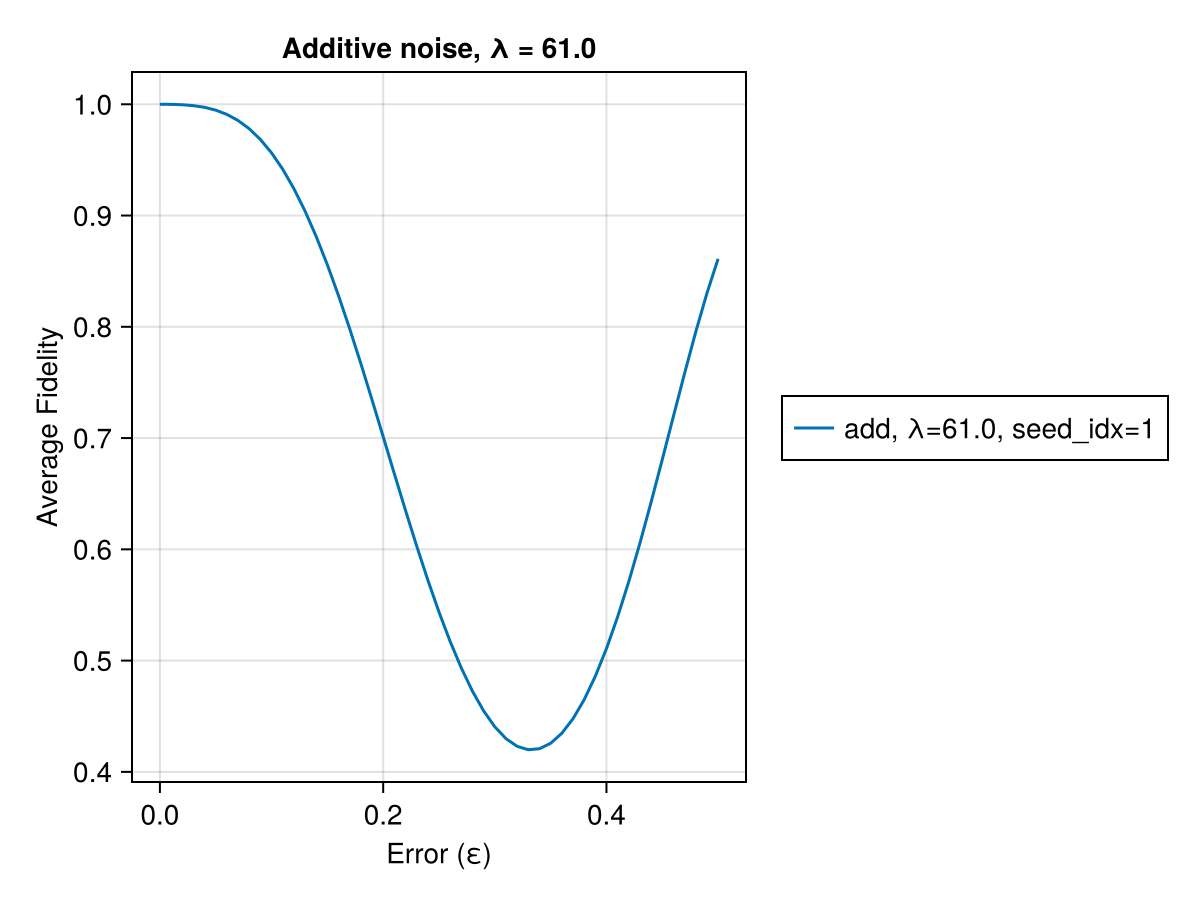

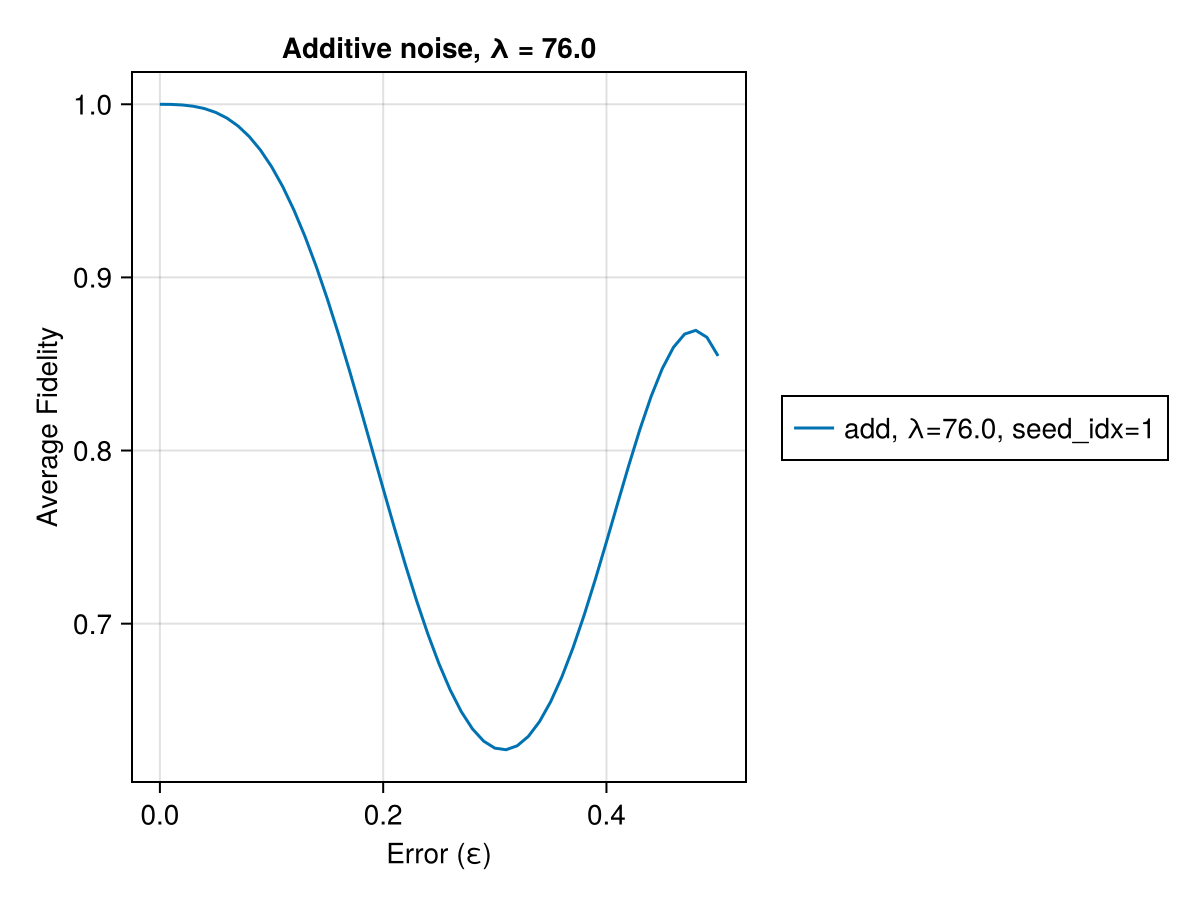

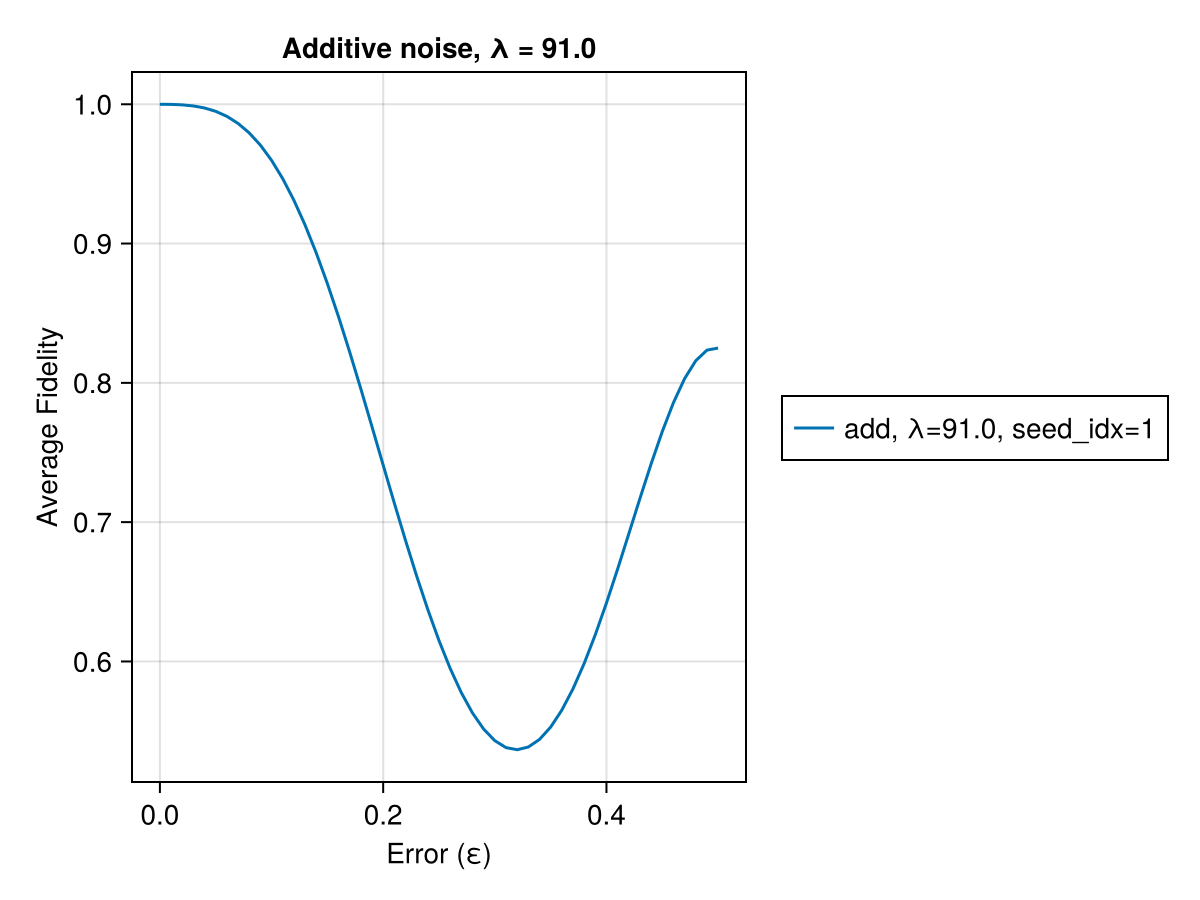

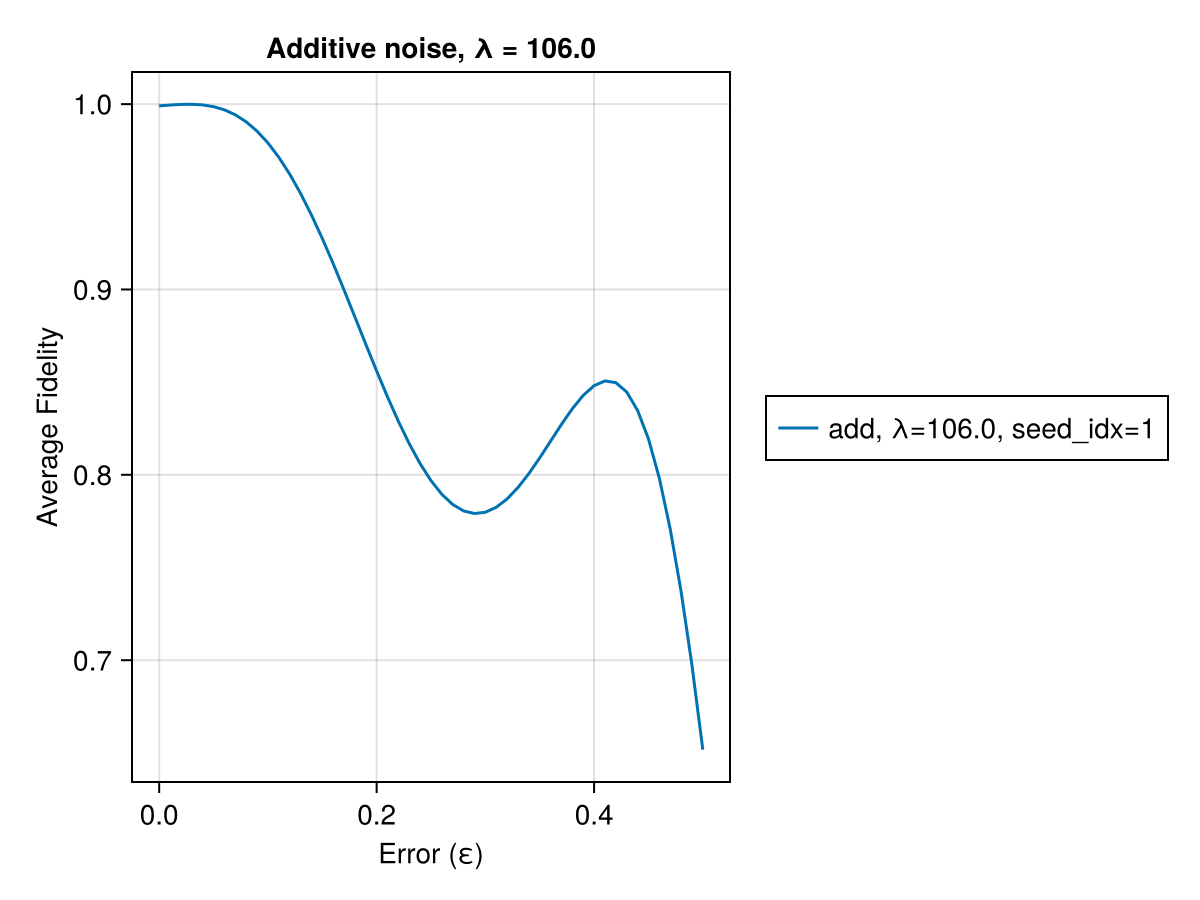

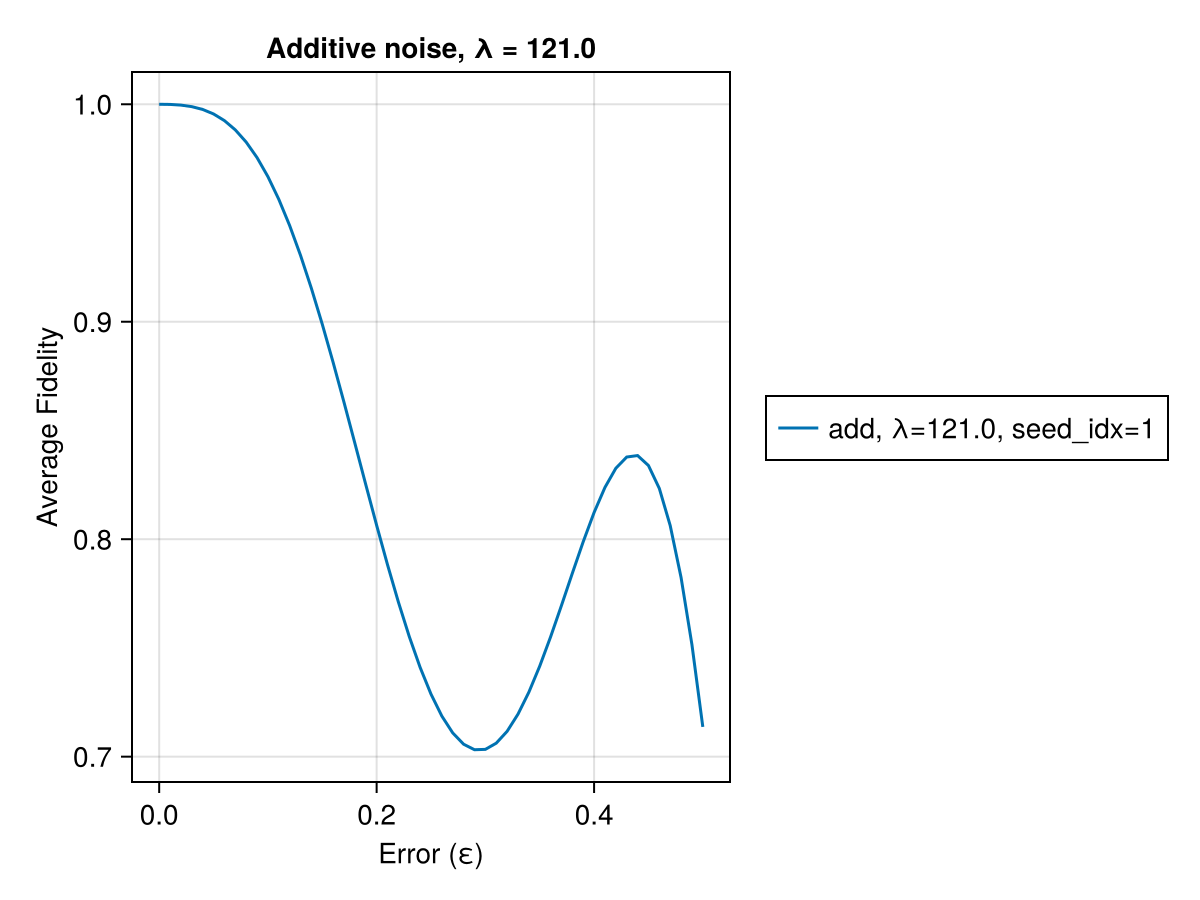

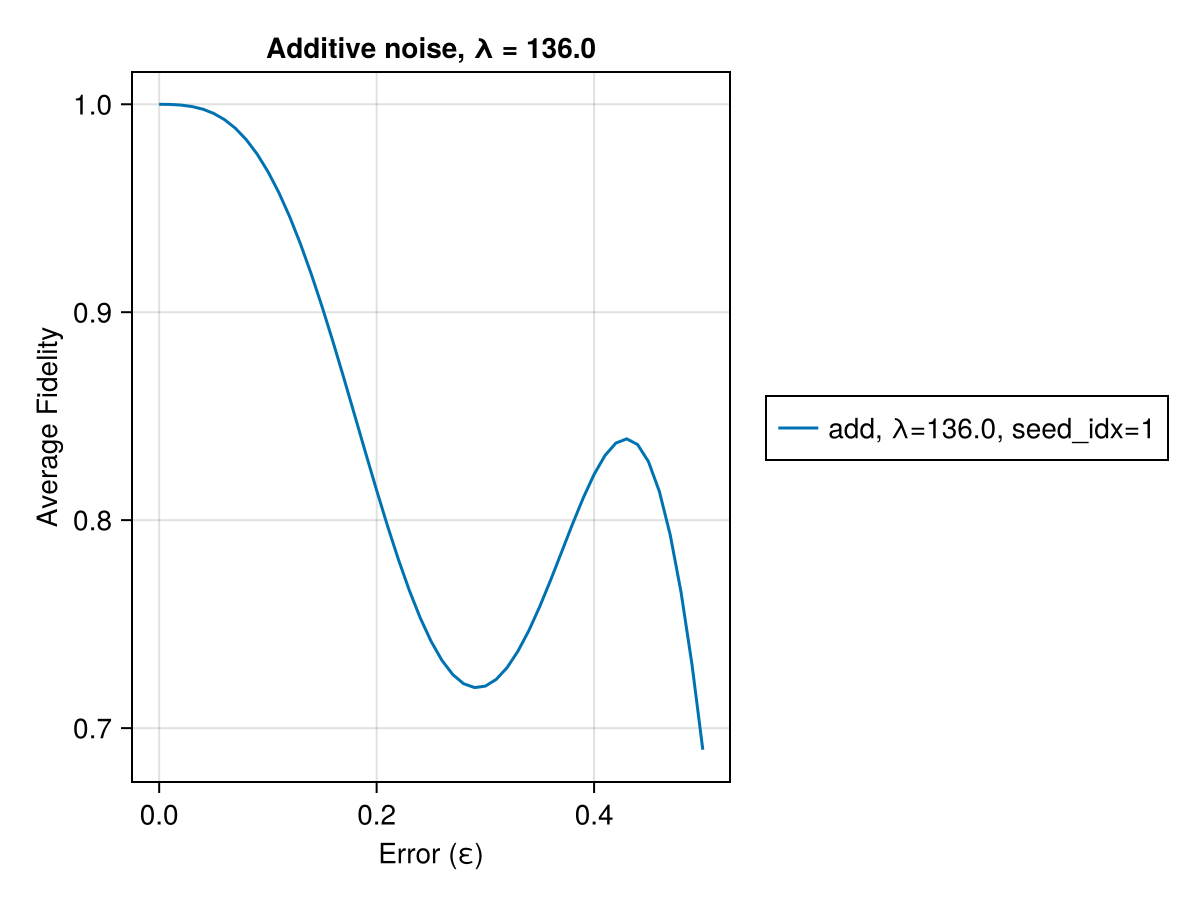

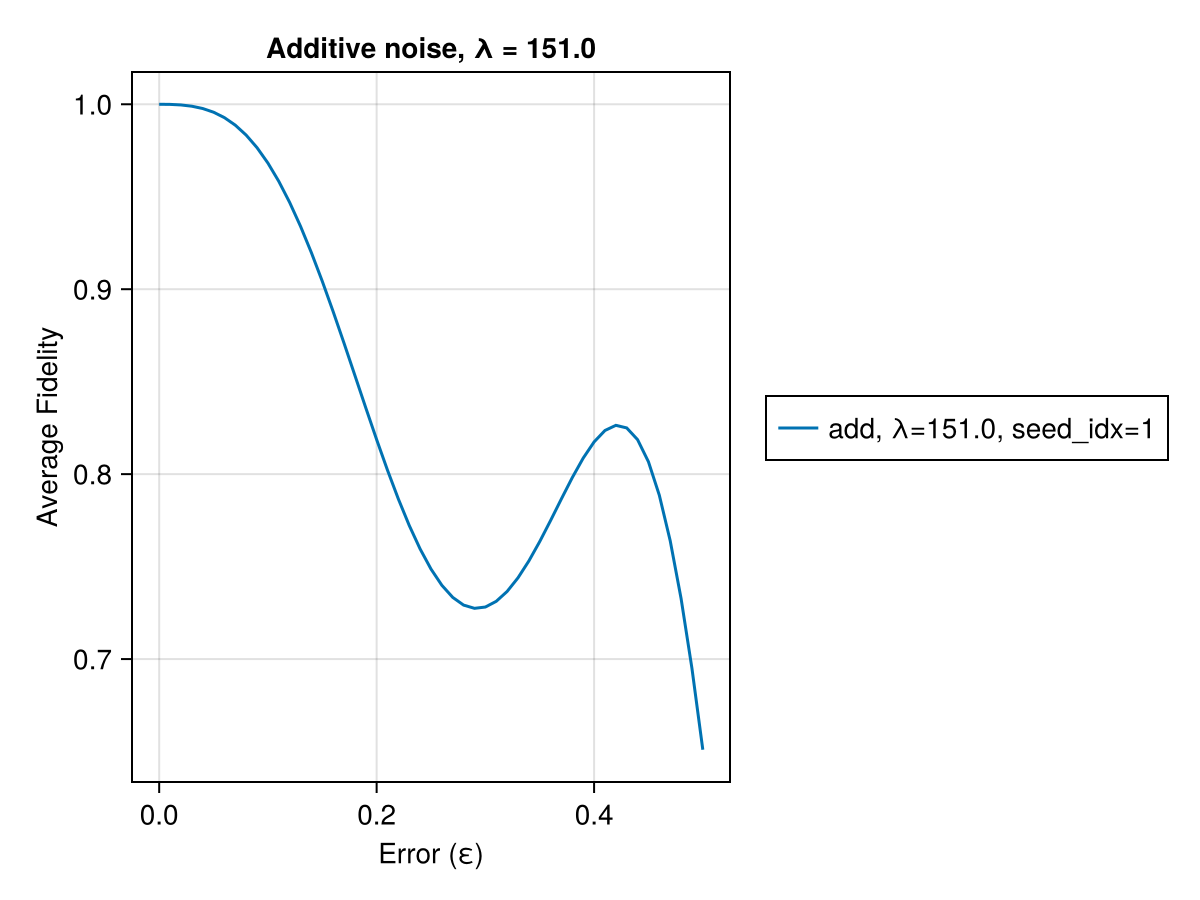

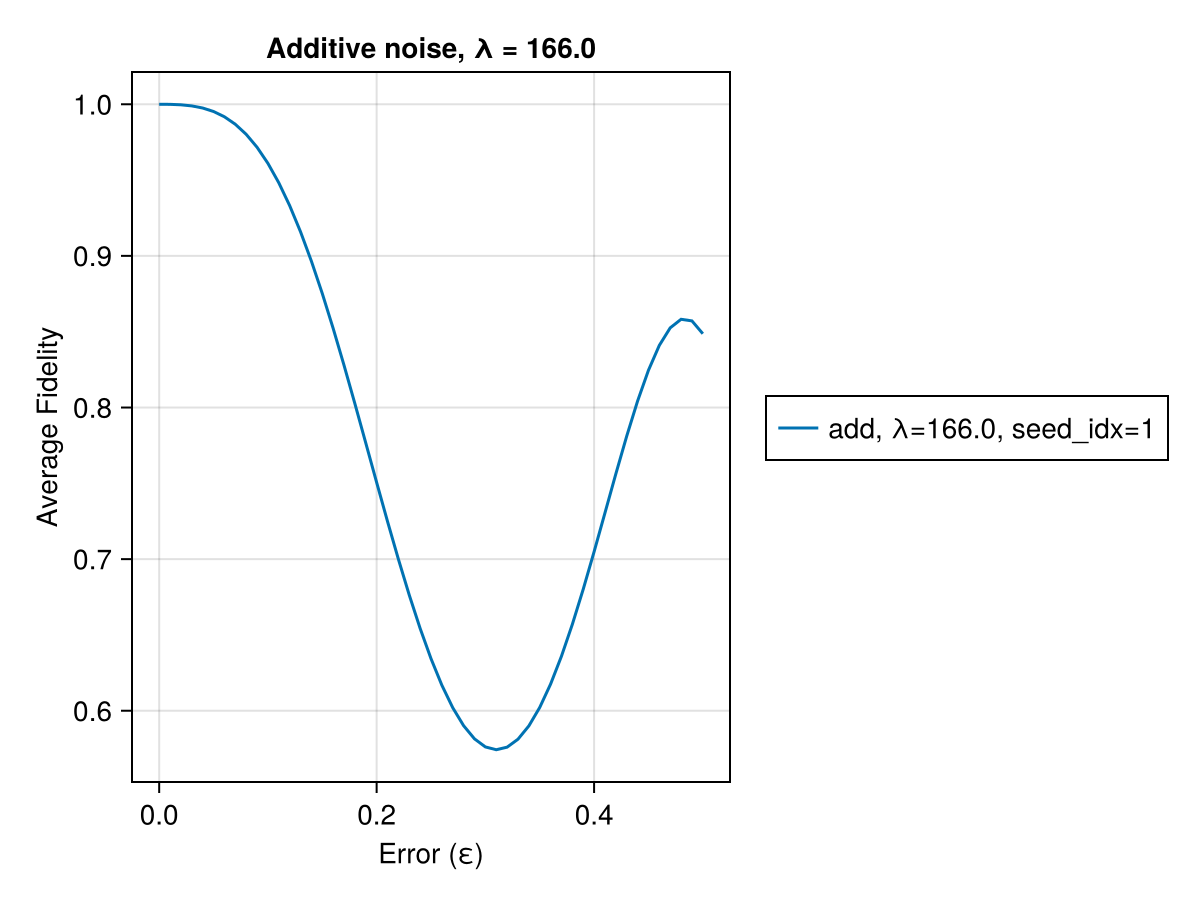

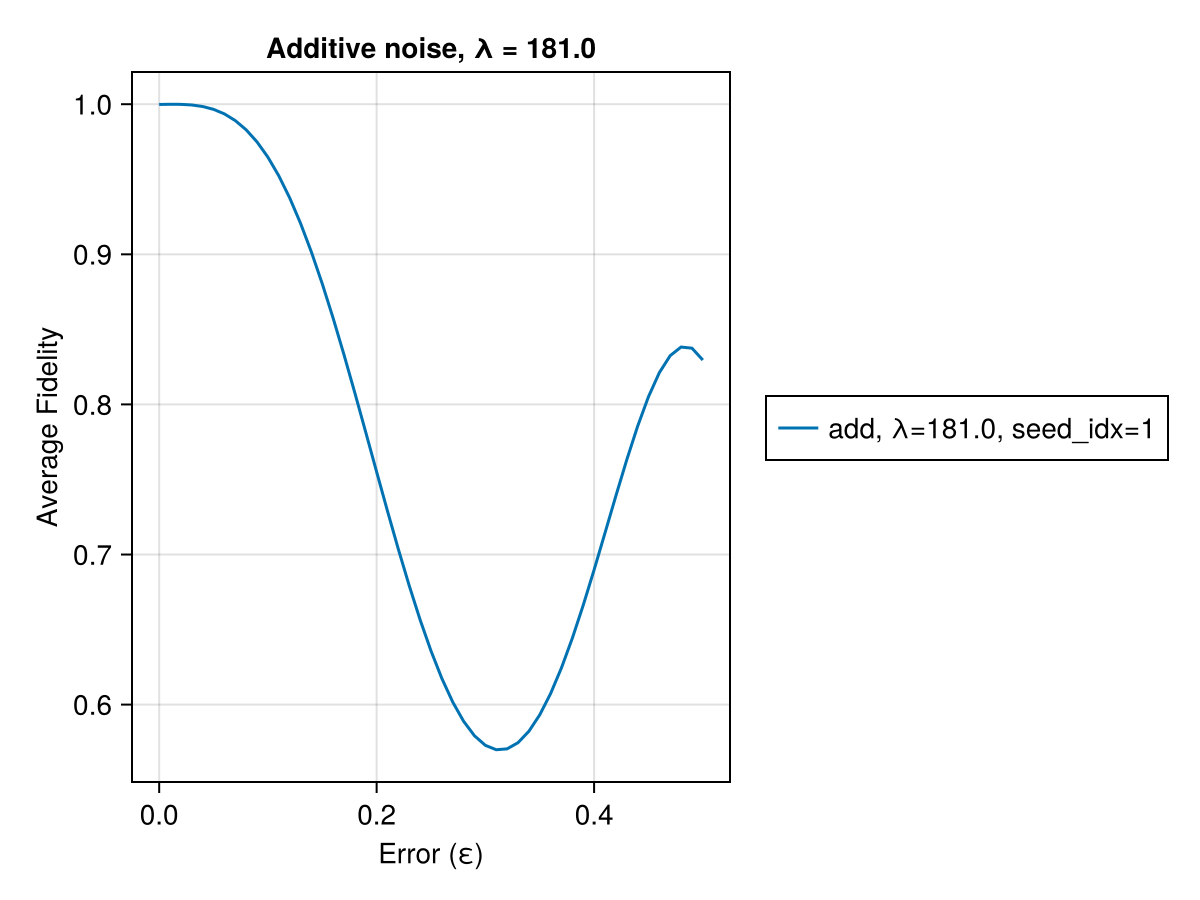

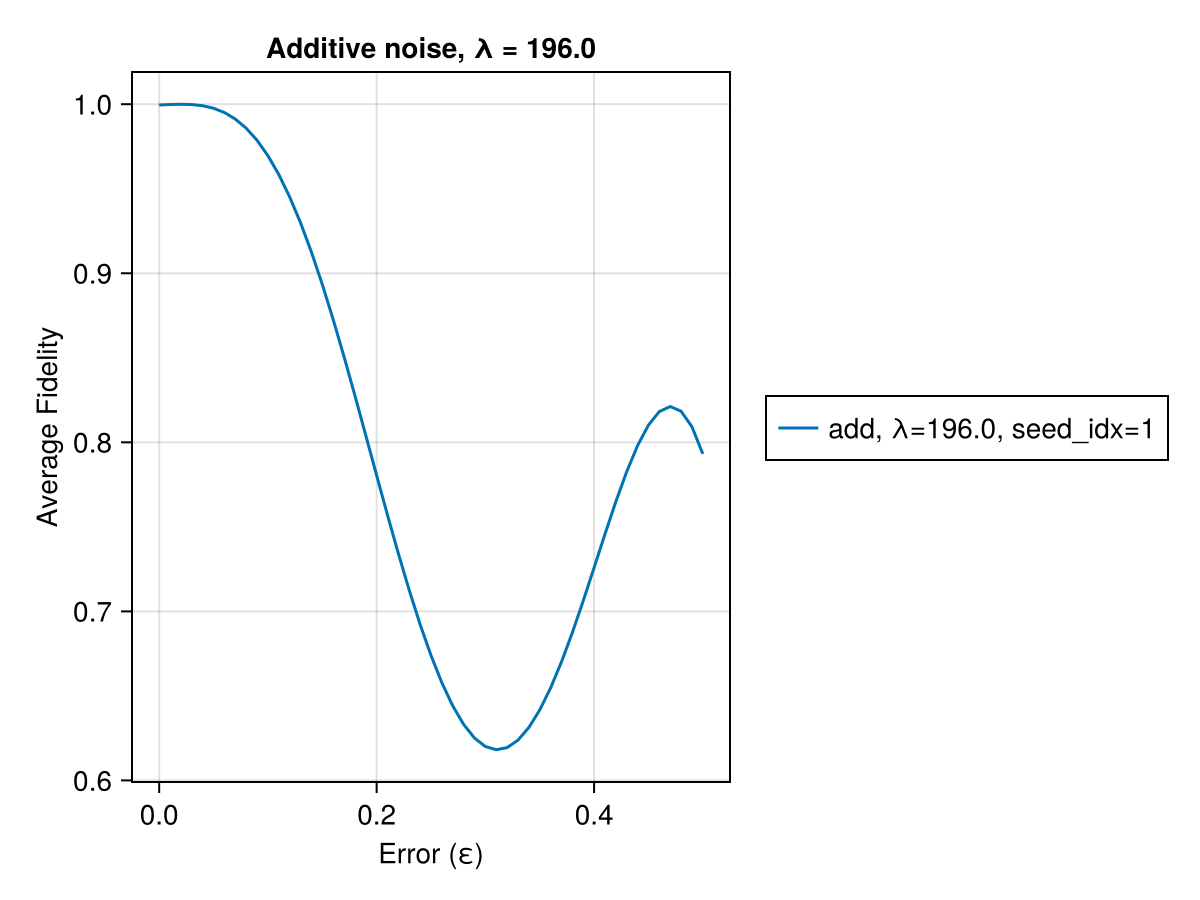

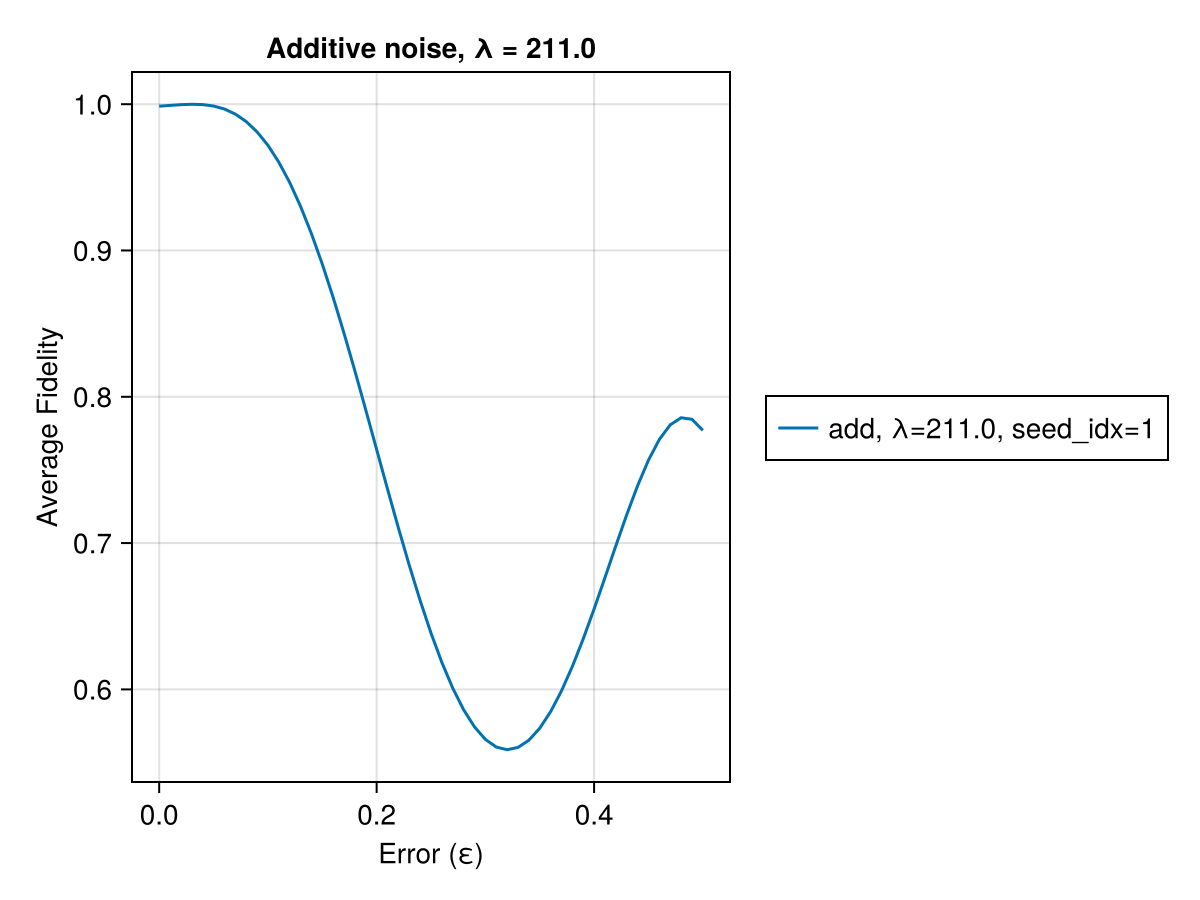

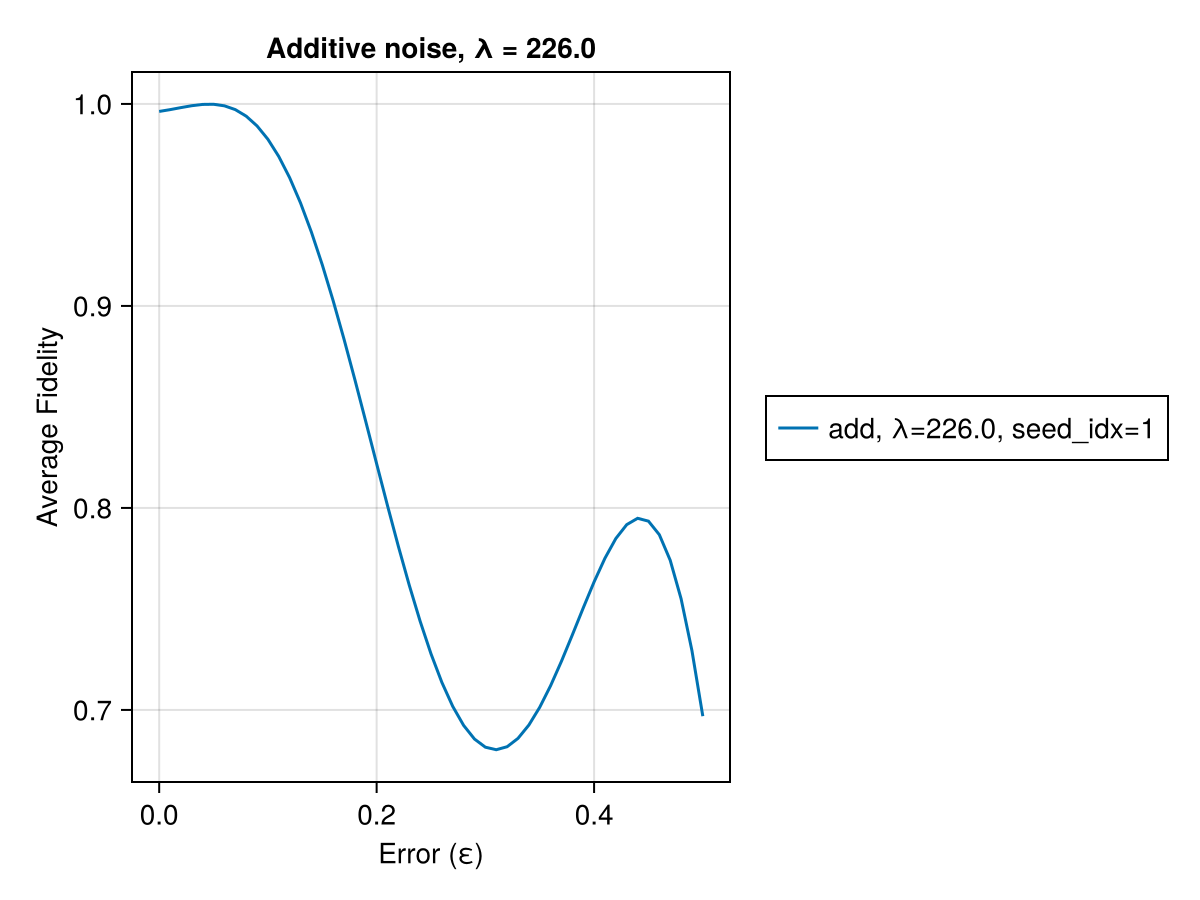

In [35]:
H_drive_add = H_drive
εs = 0:0.01:0.5
colors = Makie.wong_colors()

for seed_idx in 1:n_seeds
    for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
        println("\nProcessing λ = $λ")
        f = Figure()
        ax1 = Axis(f[1, 1], title="Additive noise, λ = $λ", xlabel="Error (ε)", ylabel="Average Fidelity")

        # Define system functions for additive and multiplicative noise
        additive_system = ε -> QuantumSystem(ε * PAULIS.X, H_drive)
        multiplicative_system = ε -> QuantumSystem((1 + ε) * H_drive)

        # Plot for both noise types
        # Additive noise
        ys_add = [unitary_rollout_fidelity(add_probs[seed_idx, λ_idx].trajectory, additive_system(ε)) for ε in εs]
        lines!(ax1, εs, ys_add, label="add, λ=$λ, seed_idx=$seed_idx", color=colors[1], linestyle=:solid)

        # Add legends
        Legend(f[1, 2], ax1, position=:lb)
        
        display(f)
    end
end


setup the same problems for the default, multiplcative, both error cases

In [36]:
default_probs = Matrix{Any}(undef, n_seeds, n_lambdas)

for i in 1:n_seeds
    for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
        defaults = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; init_trajectory=deepcopy(def_seeds[i]),)
        solve!(defaults; max_iter=250, print_level=5)
        default_probs[i,λ_idx] = defaults
    end
end

In [37]:
X_drive = sys.H.H_drives[1]
Hₑ_mult = a -> a[1] * X_drive
mult_probs = Matrix{Any}(undef, n_seeds, n_lambdas)
for i in 1:n_seeds
    for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
        # Mult problem
        mult_prob = UnitarySmoothPulseProblem(
            sys, U_goal, T, Δt;
            init_trajectory=deepcopy(mult_seeds[i]),
            piccolo_options=piccolo_opts,
            activate_rob_loss=true,
            H_err=Hₑ_mult,
            Q_t=λ
        )
        solve!(mult_prob; max_iter=250, print_level=5)
        mult_probs[i, λ_idx] = mult_prob
    end
end

In [74]:
# both_probs = Matrix{Any}(undef, n_seeds, n_lambdas)

# # Optimization loop with index counter
# for i in 1:n_seeds
#     for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
        
#         # Both problem
#         both_prob = UnitaryVariationalProblem(
#             varsys_both, U_goal, T, Δt;
#             init_trajectory=deepcopy(varsys_both_seeds[i]),
#             variational_scales=[rob_scale,rob_scale],
#             sensitive_times=[[T]],
#             piccolo_options=piccolo_opts,
#             Q_s=λ
#         )
#         solve!(both_prob; max_iter=200, print_level=5)
#         both_probs[i, λ_idx] = both_prob
#     end
# end

CompositeException: TaskFailedException

    nested task error: InterruptException:
    Stacktrace:
      [1] primal_value(x::Vector{ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}, 12}})
        @ AbstractDifferentiation ~/.julia/packages/AbstractDifferentiation/pjgzv/src/forwarddiff.jl:42
      [2] _opnormInf
        @ ~/.julia/packages/ExponentialAction/I5nOJ/src/util.jl:3 [inlined]
      [3] expv_taylor(t::ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}, 12}, A::SparseMatrixCSC{ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}, 12}, Int64}, B::Vector{ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}, 12}}, degree_max::Int64; tol::Float64)
        @ ExponentialAction ~/.julia/packages/ExponentialAction/I5nOJ/src/taylor.jl:25
      [4] expv_taylor
        @ ~/.julia/packages/ExponentialAction/I5nOJ/src/taylor.jl:18 [inlined]
      [5] _expv_core(Δt::ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}, 12}, A::SparseMatrixCSC{ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}, 12}, Int64}, B::SubArray{ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}, 12}, 1, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}, 12}}, Tuple{Vector{Int64}}, false}, degree_opt::Int64, μ::ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}, num_steps::Int64, tol::Float64)
        @ ExponentialAction ~/.julia/packages/ExponentialAction/I5nOJ/src/expv.jl:47
      [6] expv(t::ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}, 12}, A::SparseMatrixCSC{ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}, 12}, Int64}, B::SubArray{ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}, 12}, 1, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}, 12}}, Tuple{Vector{Int64}}, false}; shift::Bool, tol::Float64)
        @ ExponentialAction ~/.julia/packages/ExponentialAction/I5nOJ/src/expv.jl:38
      [7] expv
        @ ~/.julia/packages/ExponentialAction/I5nOJ/src/expv.jl:35 [inlined]
      [8] (::BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}})(δₖ::Vector{ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}, 12}}, zₖ::SubArray{ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}, 12}, 1, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}, 12}}, Tuple{UnitRange{Int64}}, true}, zₖ₊₁::SubArray{ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}, 12}, 1, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}, 12}}, Tuple{UnitRange{Int64}}, true})
        @ DirectTrajOpt.Integrators ~/.julia/packages/DirectTrajOpt/7J4T8/src/integrators/bilinear_integrator.jl:154
      [9] (::DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}})(zz::Vector{ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}, 12}})
        @ DirectTrajOpt.Integrators ~/.julia/packages/DirectTrajOpt/7J4T8/src/integrators/bilinear_integrator.jl:65
     [10] chunk_mode_gradient(f::DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, x::Vector{ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}}, cfg::ForwardDiff.GradientConfig{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}, 12, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}, 12}}})
        @ ForwardDiff ~/.julia/packages/ForwardDiff/Wq9Wb/src/gradient.jl:132
     [11] gradient
        @ ~/.julia/packages/ForwardDiff/Wq9Wb/src/gradient.jl:22 [inlined]
     [12] #107
        @ ~/.julia/packages/ForwardDiff/Wq9Wb/src/hessian.jl:17 [inlined]
     [13] chunk_mode_jacobian(f::ForwardDiff.var"#107#108"{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, ForwardDiff.HessianConfig{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}, 12}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}}}}, x::Vector{Float64}, cfg::ForwardDiff.JacobianConfig{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}}})
        @ ForwardDiff ~/.julia/packages/ForwardDiff/Wq9Wb/src/jacobian.jl:198
     [14] jacobian
        @ ~/.julia/packages/ForwardDiff/Wq9Wb/src/jacobian.jl:24 [inlined]
     [15] hessian
        @ ~/.julia/packages/ForwardDiff/Wq9Wb/src/hessian.jl:18 [inlined]
     [16] hessian(f::DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, x::Vector{Float64}, cfg::ForwardDiff.HessianConfig{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}, 12}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, Float64}, Float64, 12}}})
        @ ForwardDiff ~/.julia/packages/ForwardDiff/Wq9Wb/src/hessian.jl:15
     [17] hessian(f::DirectTrajOpt.Integrators.var"#3#4"{BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}}, x::Vector{Float64})
        @ ForwardDiff ~/.julia/packages/ForwardDiff/Wq9Wb/src/hessian.jl:15
     [18] hessian_of_lagrangian
        @ ~/.julia/packages/DirectTrajOpt/7J4T8/src/integrators/bilinear_integrator.jl:62 [inlined]
     [19] macro expansion
        @ ~/.julia/packages/DirectTrajOpt/7J4T8/src/dynamics.jl:172 [inlined]
     [20] (::DirectTrajOpt.Dynamics.var"#144#threadsfor_fun#17"{DirectTrajOpt.Dynamics.var"#144#threadsfor_fun#5#18"{Vector{SparseMatrixCSC{Float64, Int64}}, Vector{Float64}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}, UnitRange{Int64}, BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, UnitRange{Int64}, NamedTrajectory{Float64, (:Ũ⃗, :a, :da, :dda, :Δt, :Ũ⃗ᵥ1, :Ũ⃗ᵥ2), NTuple{7, Int64}, (:a, :da, :dda, :Δt), NTuple{4, Tuple{Vector{Float64}, Vector{Float64}}}, (:Ũ⃗, :a, :Ũ⃗ᵥ1, :Ũ⃗ᵥ2), NTuple{4, Vector{Float64}}, (:a,), Tuple{Vector{Float64}}, (:Ũ⃗,), Tuple{Vector{Float64}}, (:Ũ⃗, :a, :da, :dda, :Δt, :Ũ⃗ᵥ1, :Ũ⃗ᵥ2), NTuple{7, UnitRange{Int64}}, NTuple{7, Symbol}, NTuple{5, Symbol}, Tuple{Symbol, Symbol}, (), Tuple{}, (), Tuple{}, Tuple{}}, Int64}})(tid::Int64; onethread::Bool)
        @ DirectTrajOpt.Dynamics ./threadingconstructs.jl:253
     [21] #144#threadsfor_fun
        @ ./threadingconstructs.jl:220 [inlined]
     [22] (::Base.Threads.var"#1#2"{DirectTrajOpt.Dynamics.var"#144#threadsfor_fun#17"{DirectTrajOpt.Dynamics.var"#144#threadsfor_fun#5#18"{Vector{SparseMatrixCSC{Float64, Int64}}, Vector{Float64}, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}, UnitRange{Int64}, BilinearIntegrator{QuantumCollocation.QuantumIntegrators.var"#Ĝ#9"{Vector{Float64}, VariationalQuantumSystem{var"#81#84", PiccoloQuantumObjects.QuantumSystems.var"#54#65"{var"#81#84"}, Vector{Function}}}}, UnitRange{Int64}, NamedTrajectory{Float64, (:Ũ⃗, :a, :da, :dda, :Δt, :Ũ⃗ᵥ1, :Ũ⃗ᵥ2), NTuple{7, Int64}, (:a, :da, :dda, :Δt), NTuple{4, Tuple{Vector{Float64}, Vector{Float64}}}, (:Ũ⃗, :a, :Ũ⃗ᵥ1, :Ũ⃗ᵥ2), NTuple{4, Vector{Float64}}, (:a,), Tuple{Vector{Float64}}, (:Ũ⃗,), Tuple{Vector{Float64}}, (:Ũ⃗, :a, :da, :dda, :Δt, :Ũ⃗ᵥ1, :Ũ⃗ᵥ2), NTuple{7, UnitRange{Int64}}, NTuple{7, Symbol}, NTuple{5, Symbol}, Tuple{Symbol, Symbol}, (), Tuple{}, (), Tuple{}, Tuple{}}, Int64}}, Int64})()
        @ Base.Threads ./threadingconstructs.jl:154

plot fid v err magnitude for the above problems

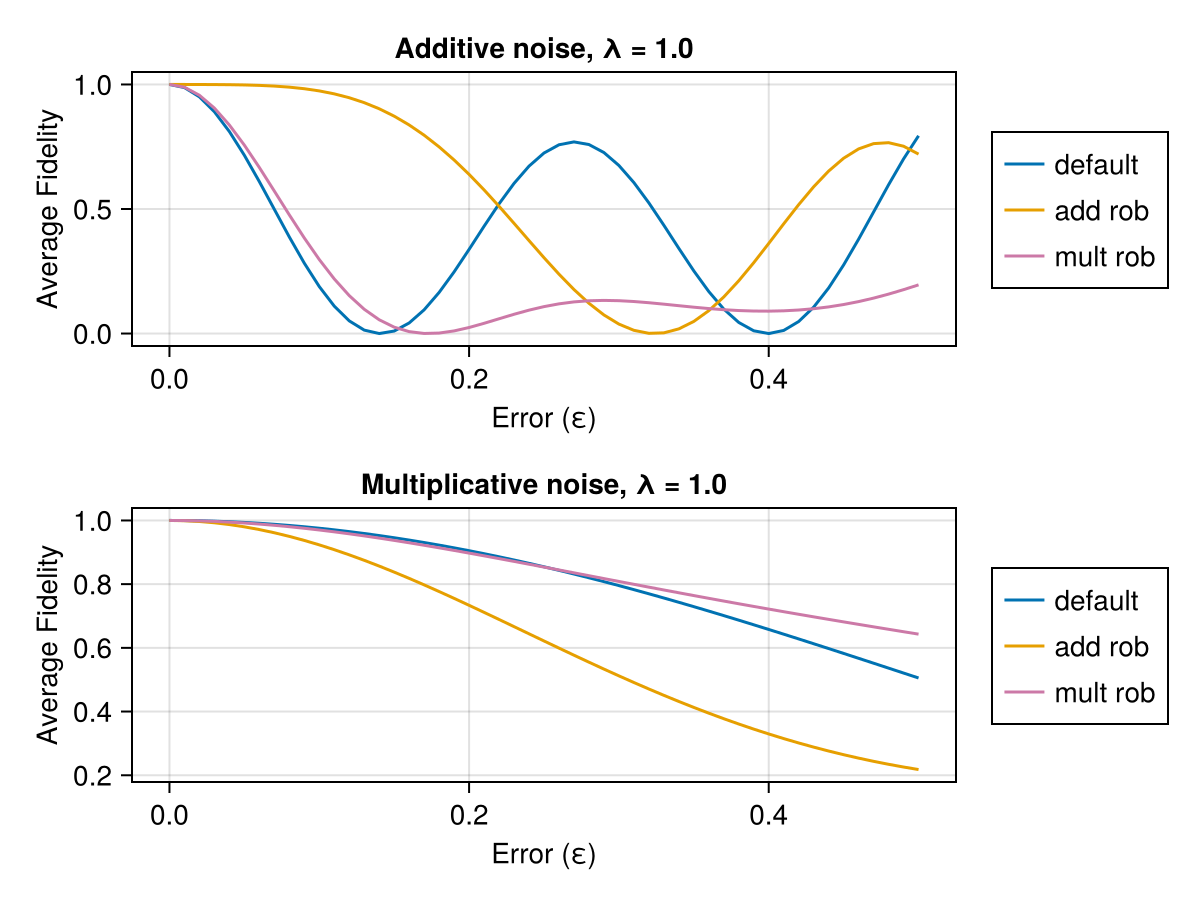

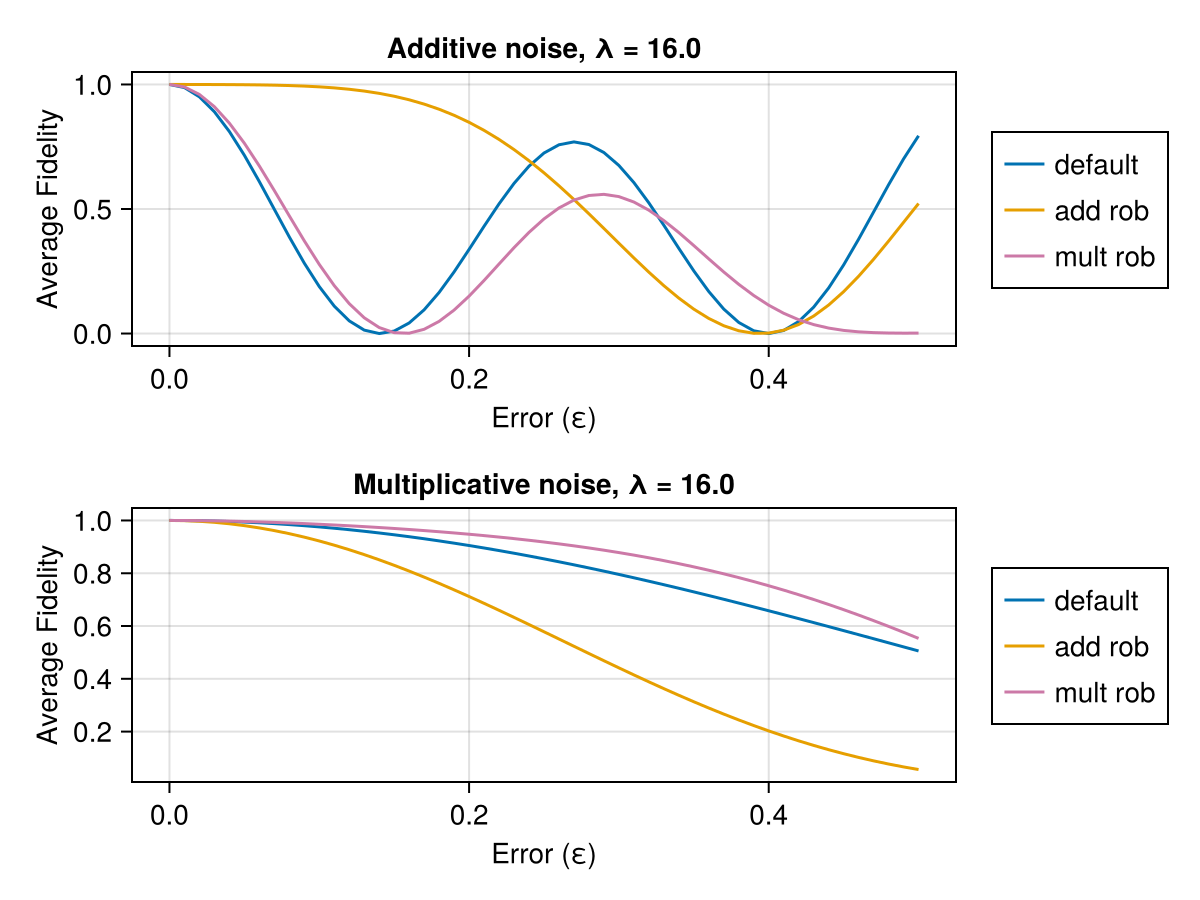

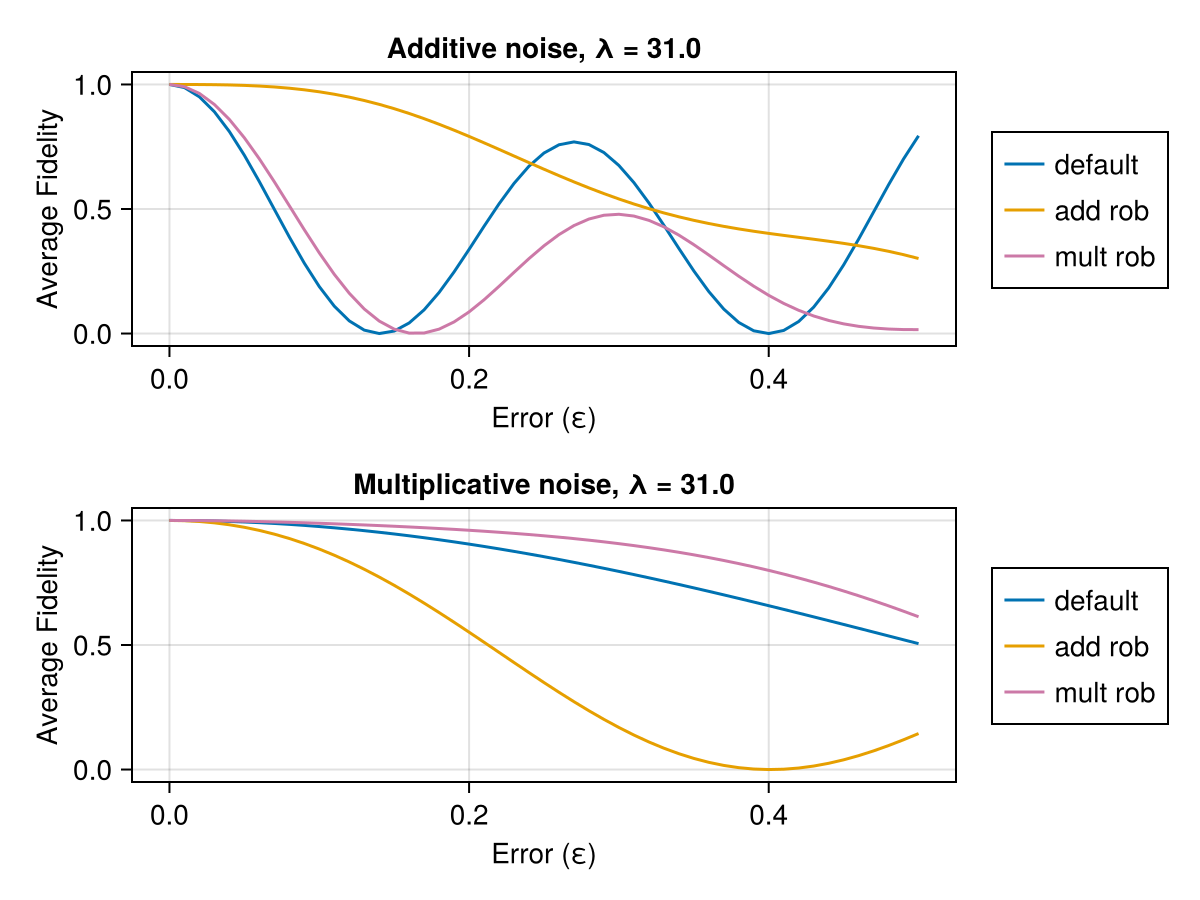

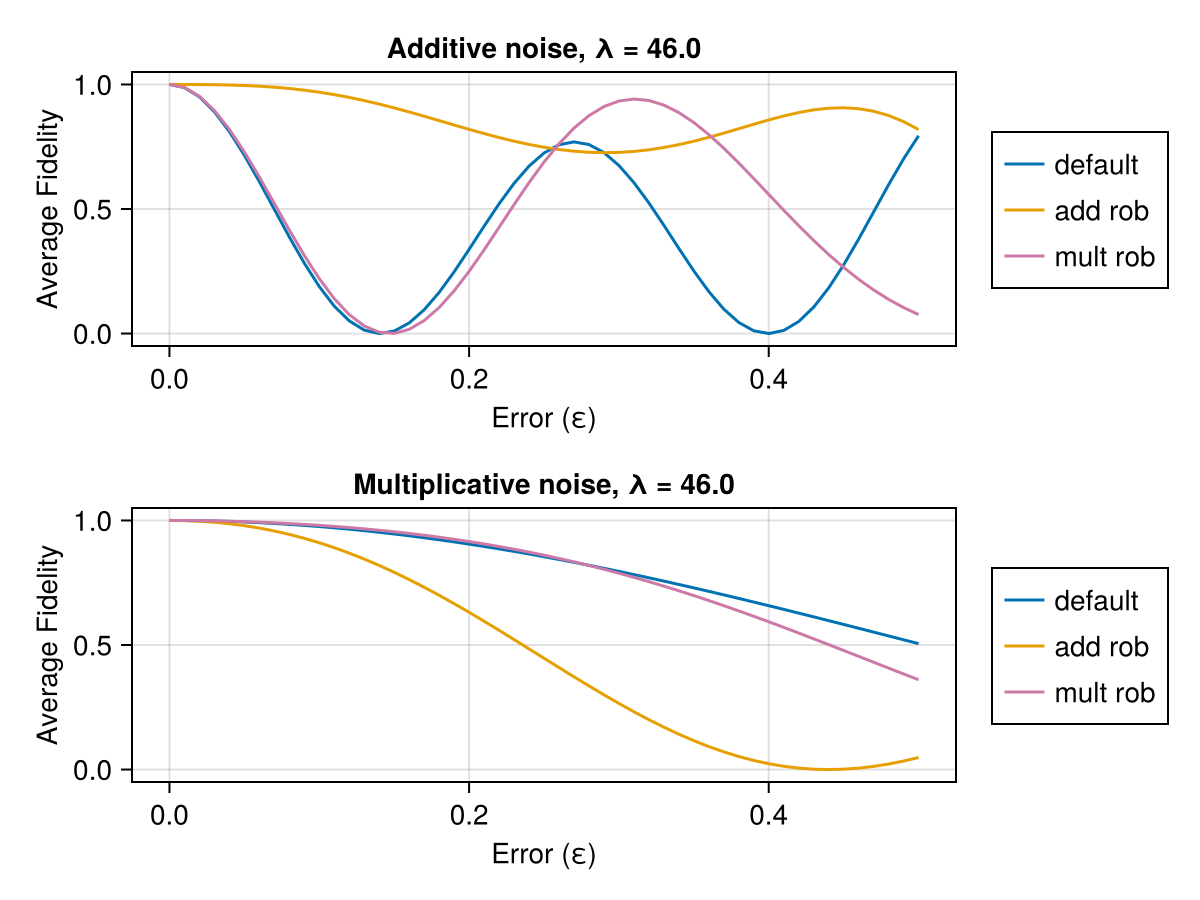

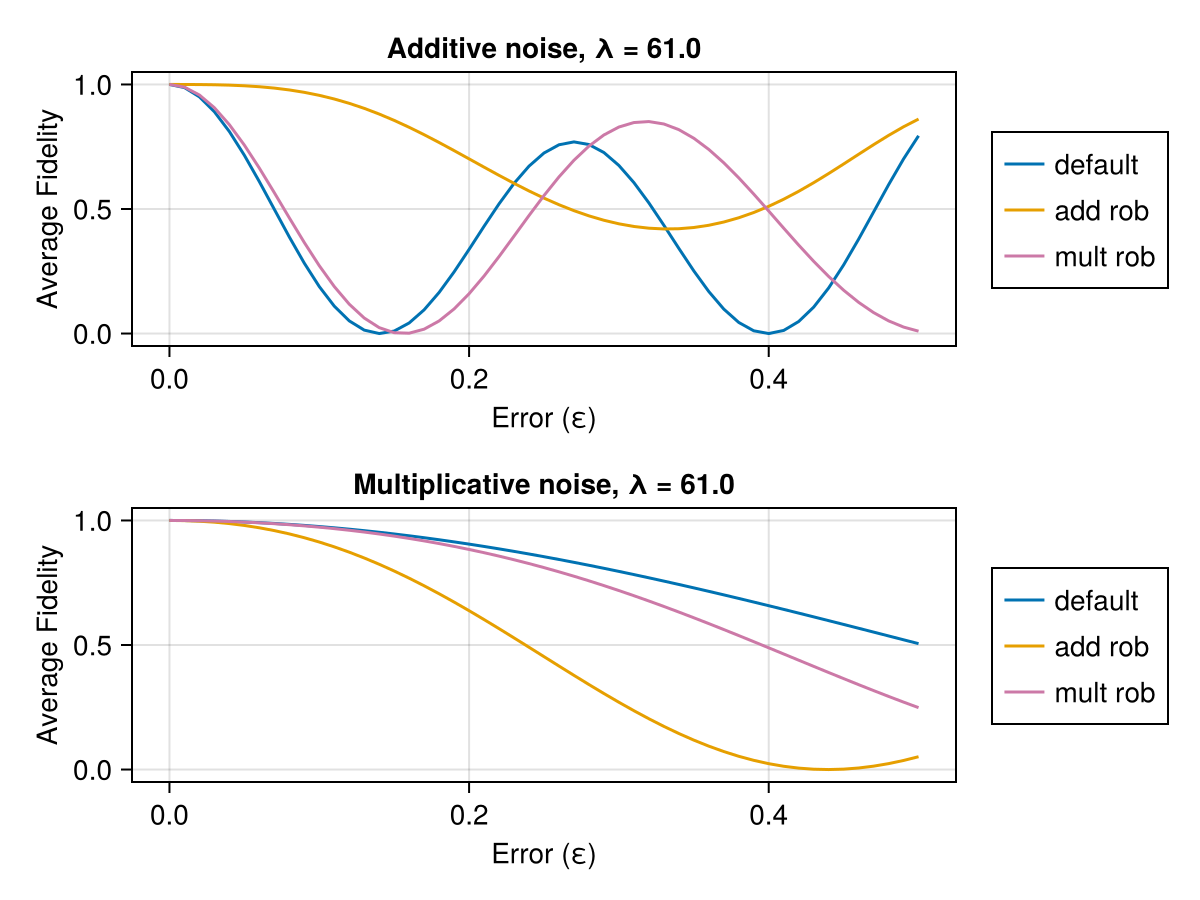

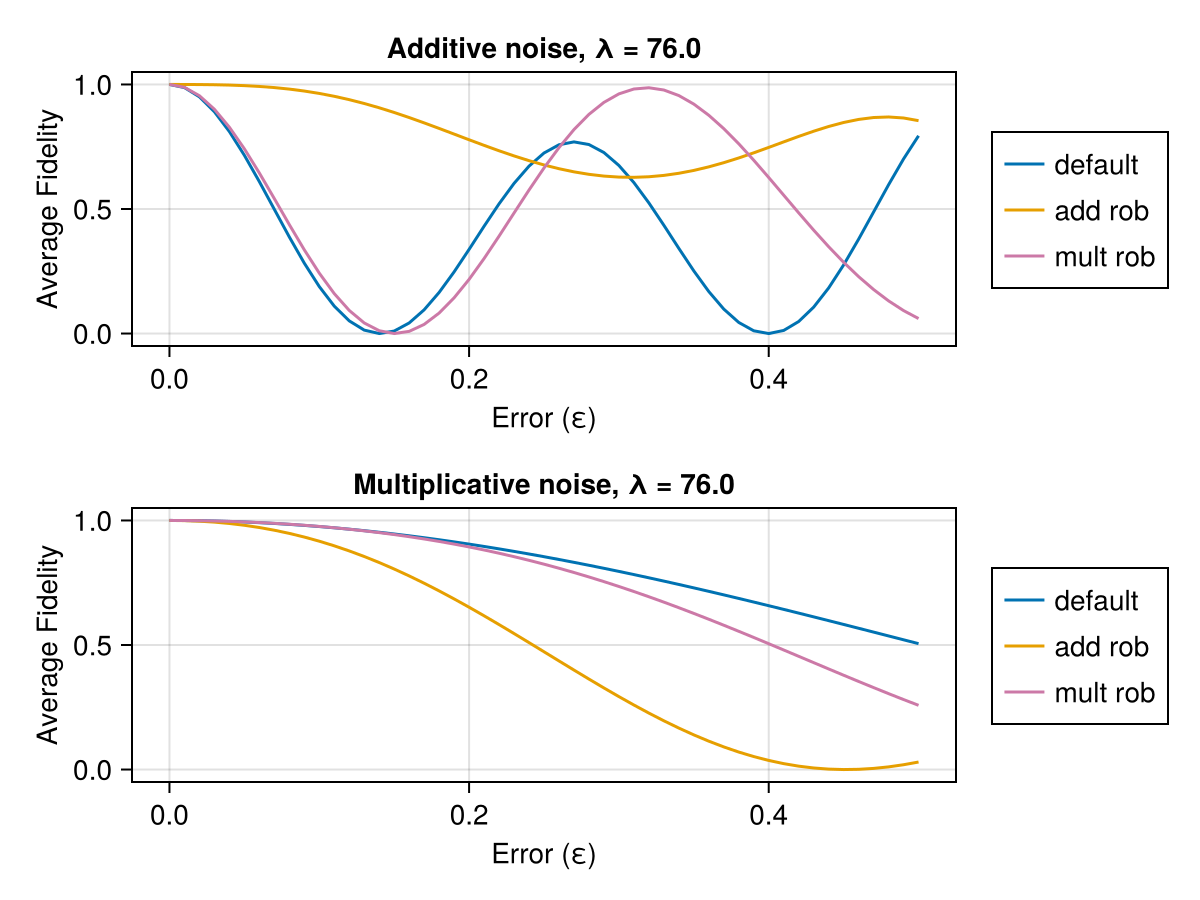

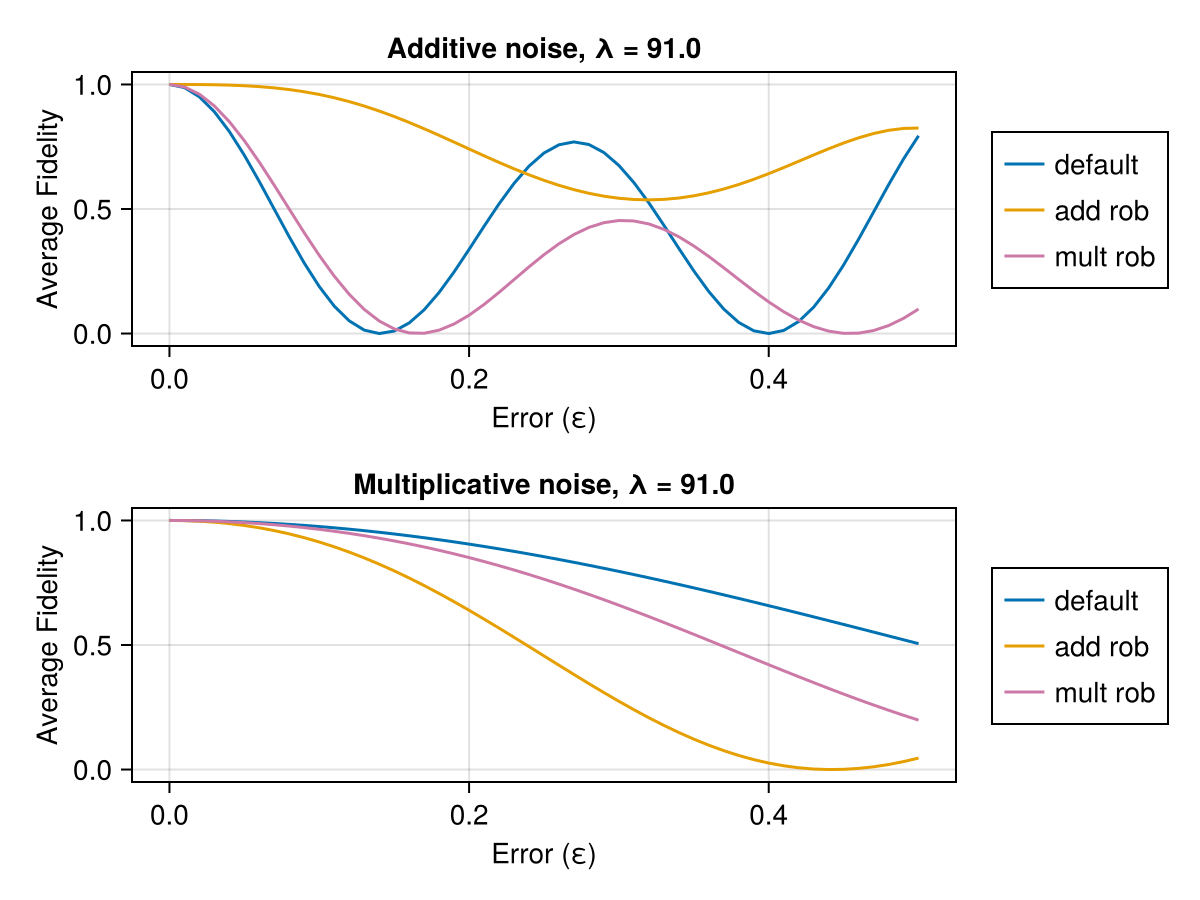

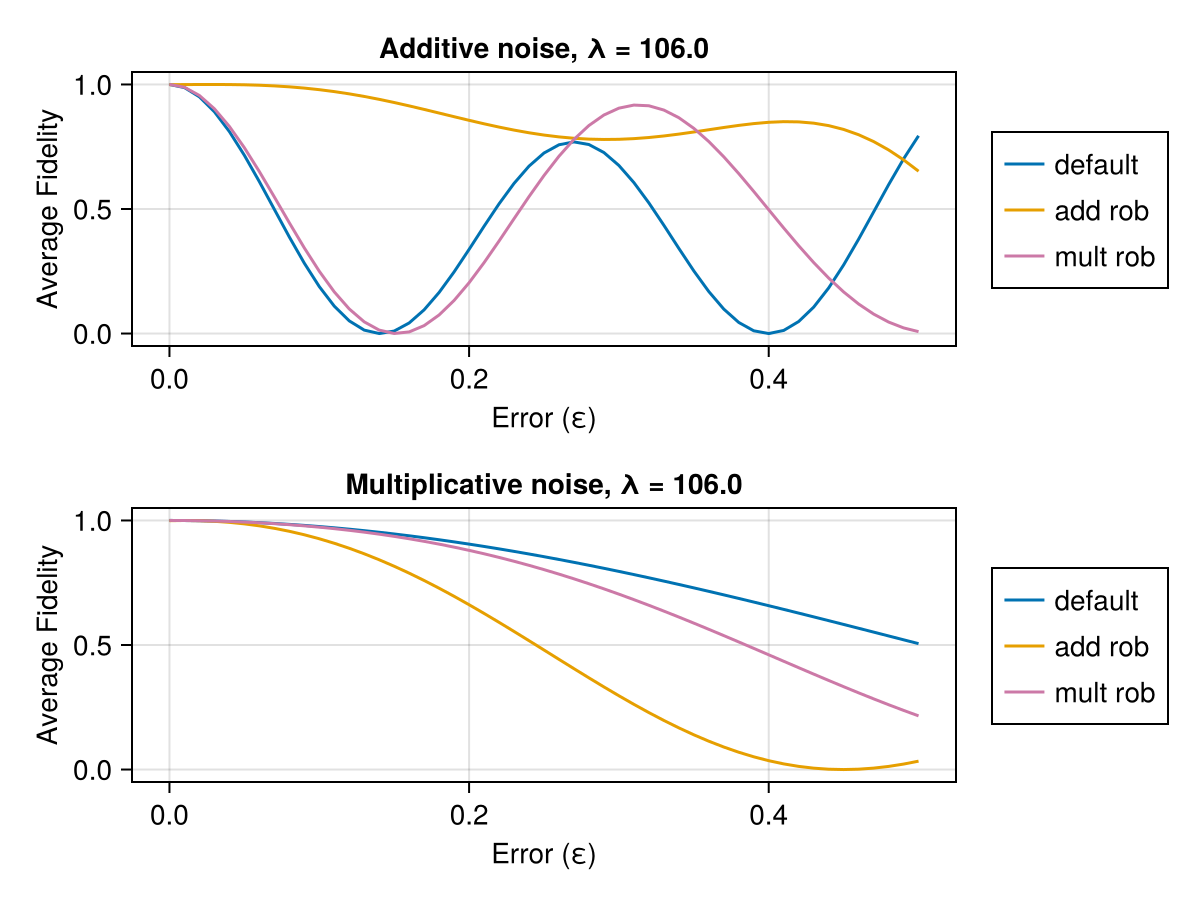

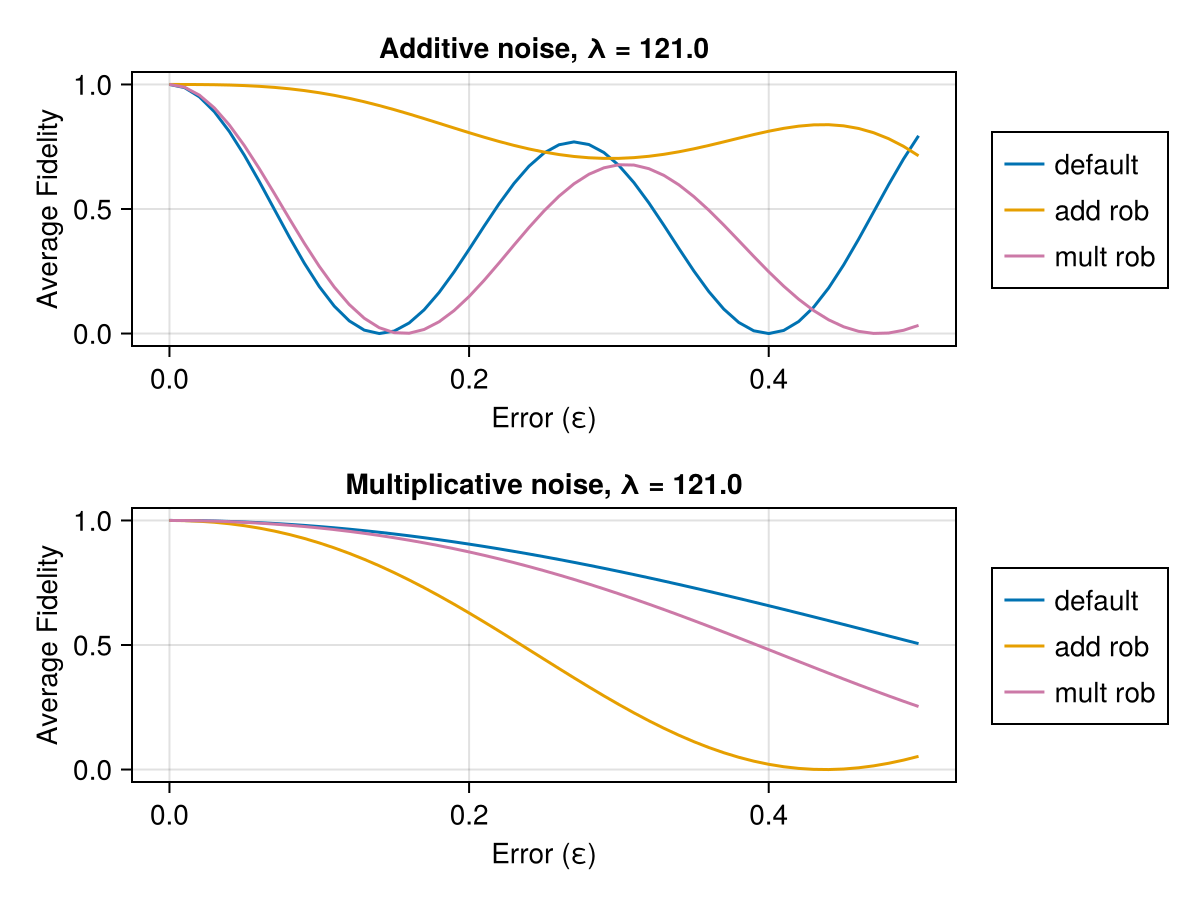

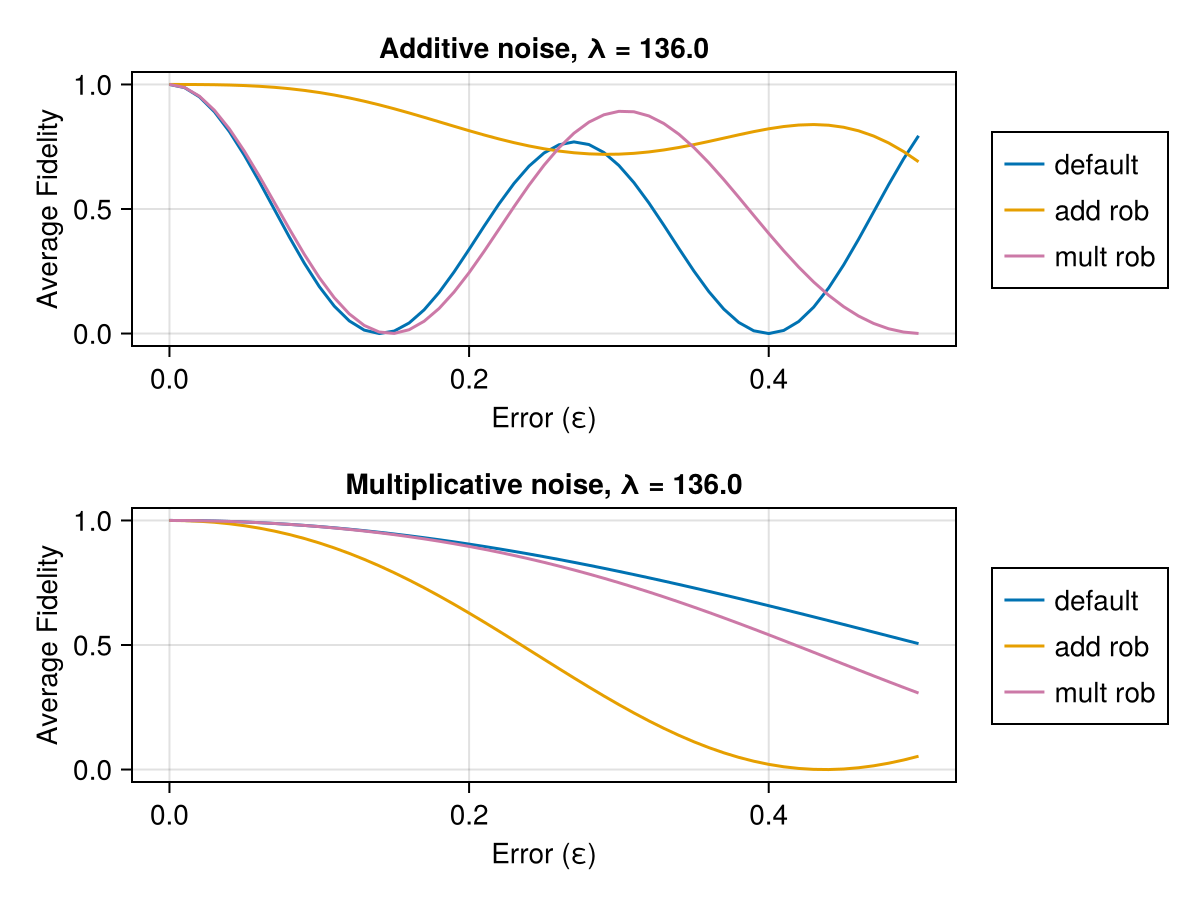

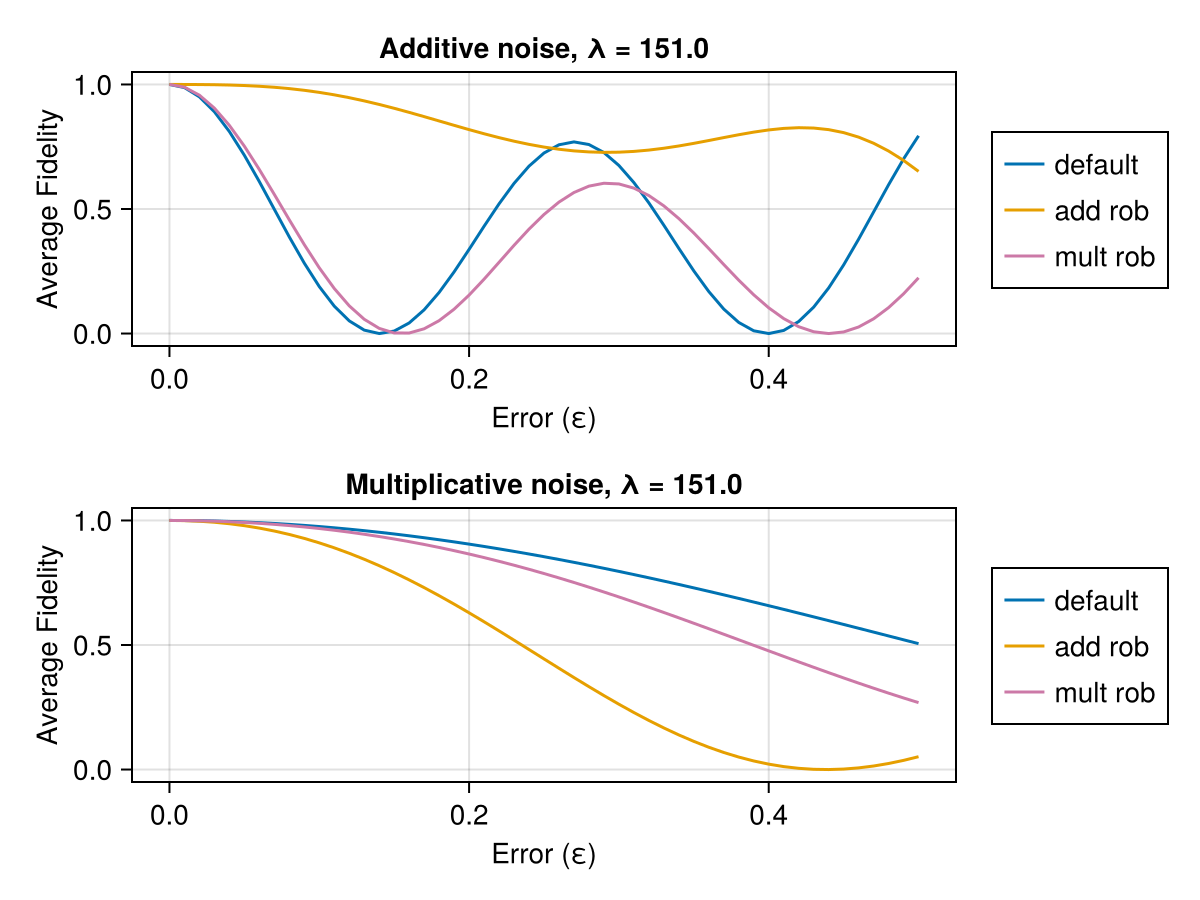

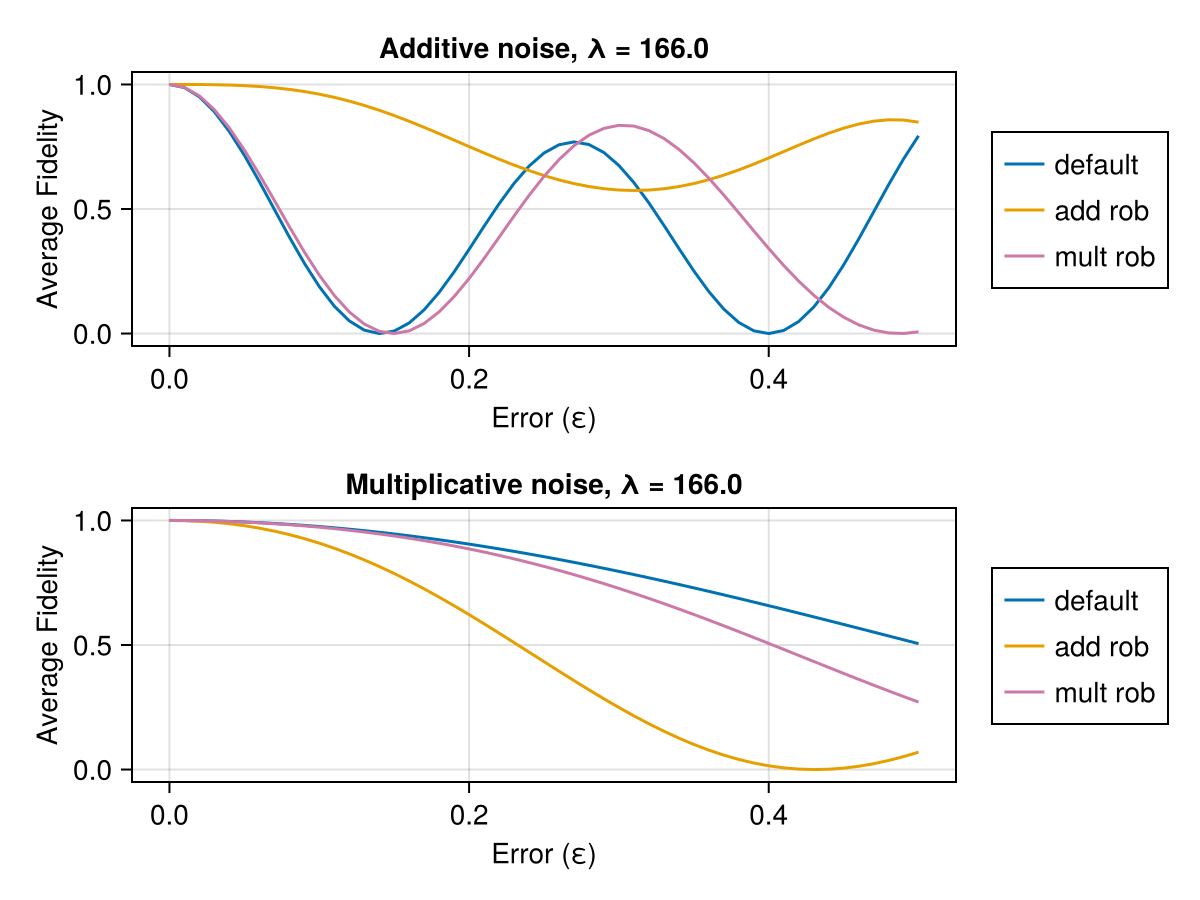

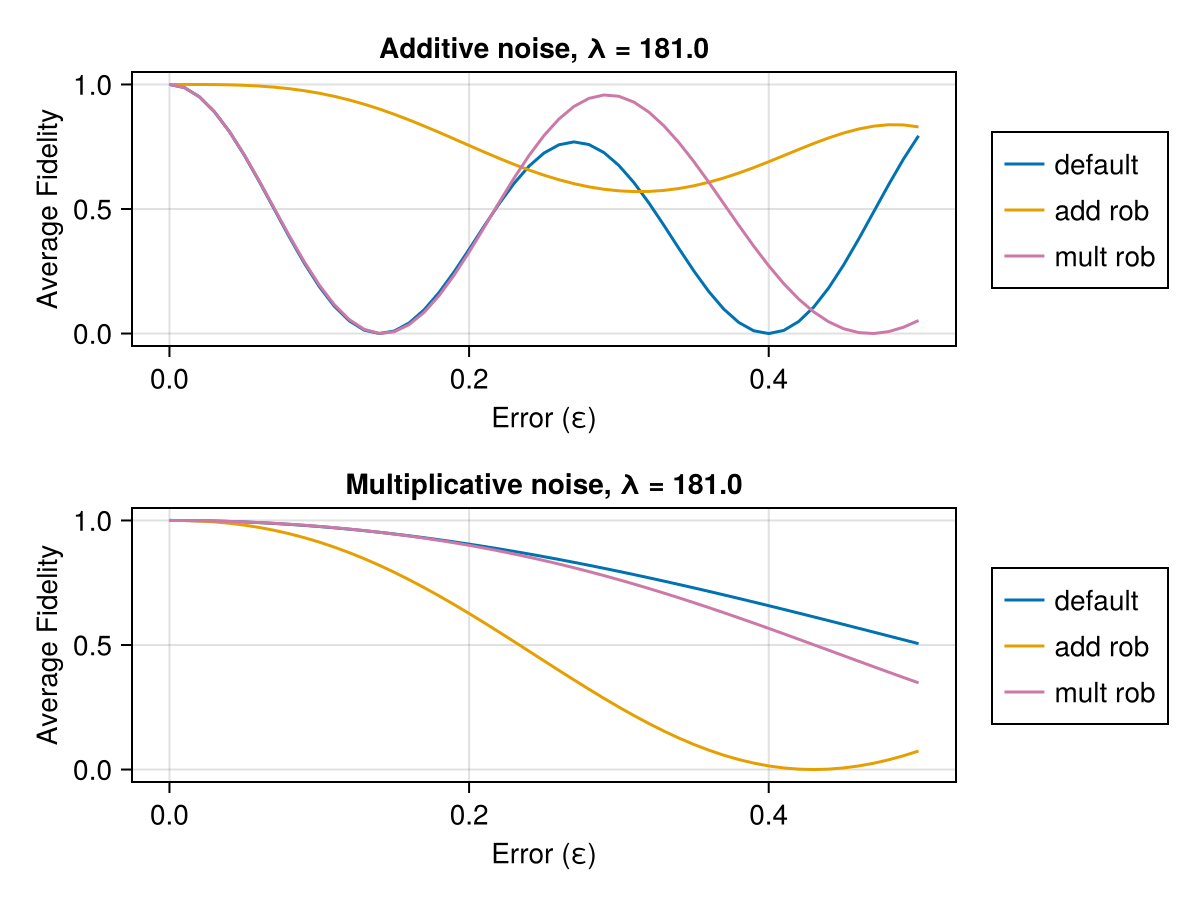

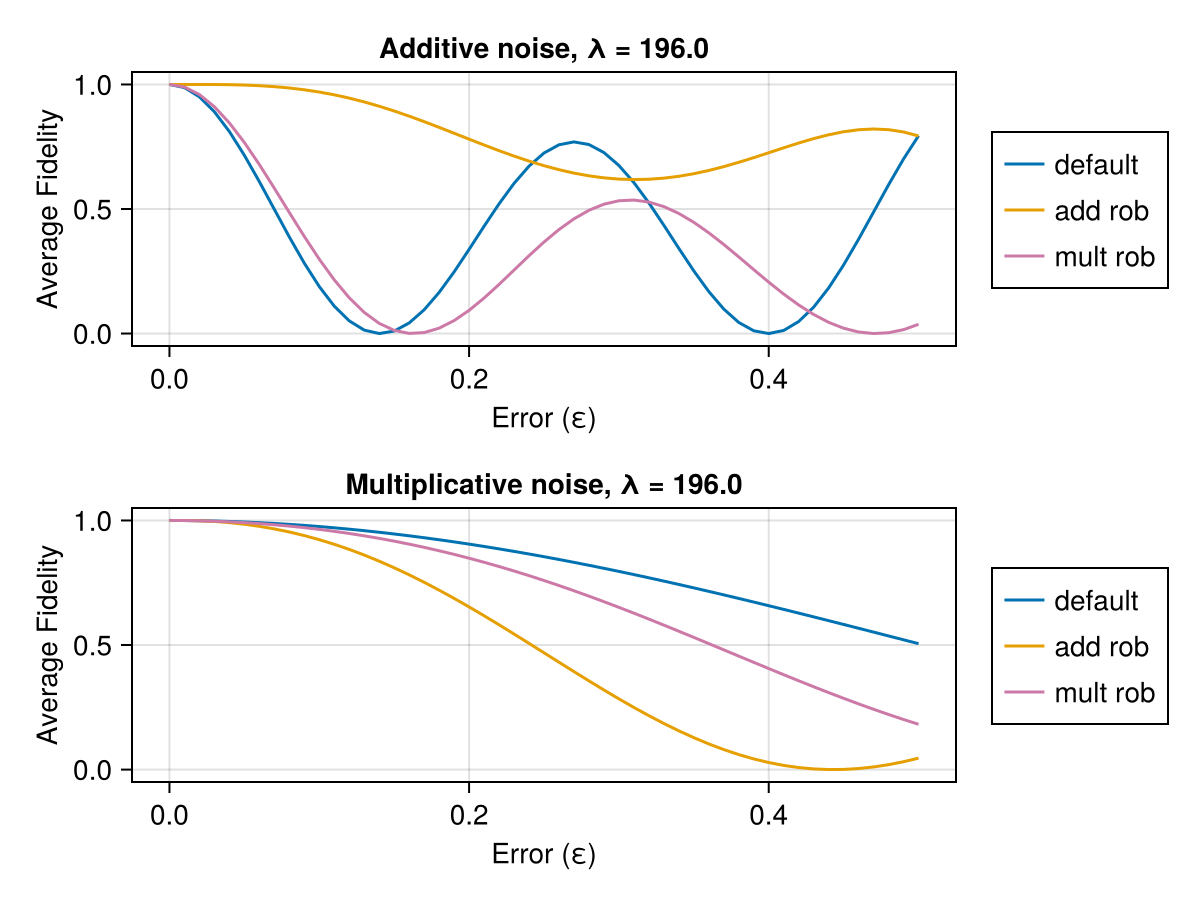

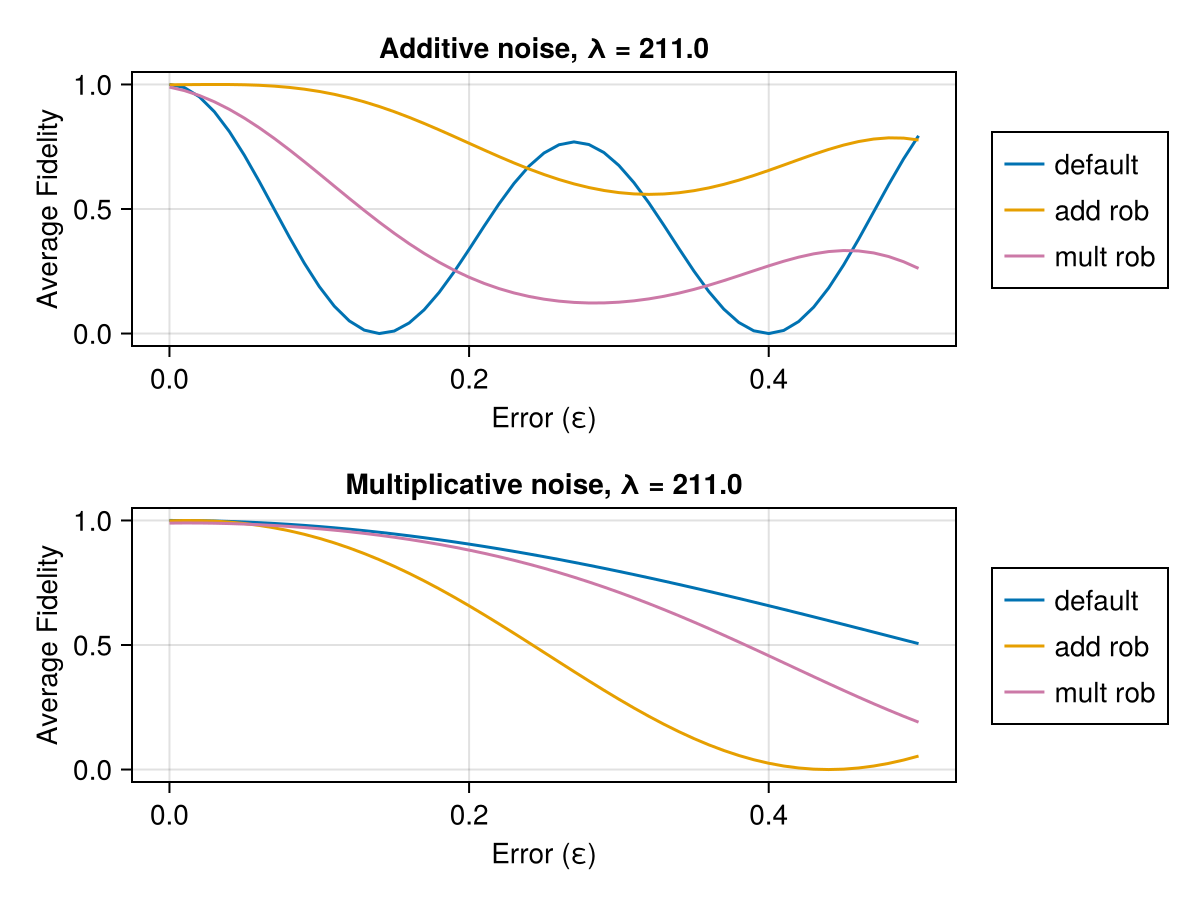

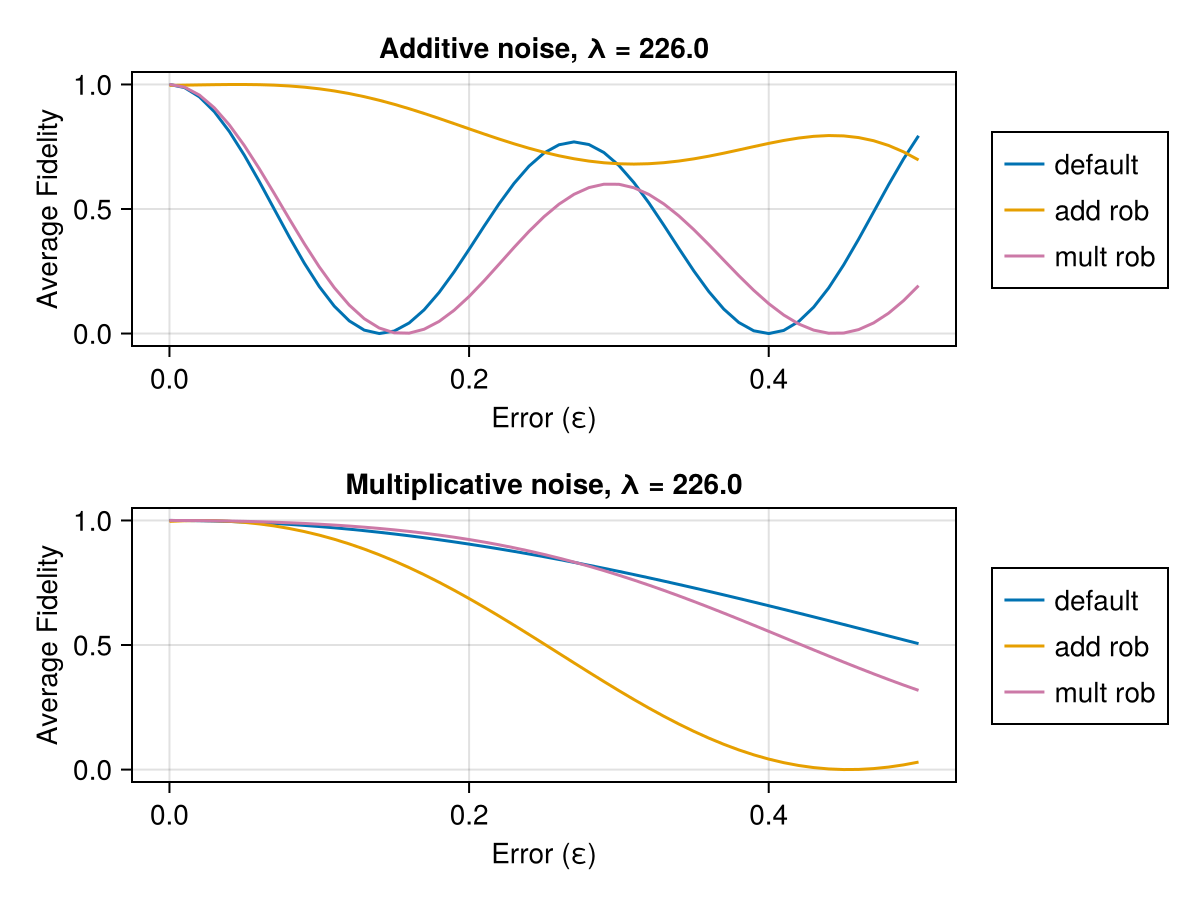

In [45]:
H_drive_add = H_drive
εs = 0:0.01:0.5
colors = Makie.wong_colors()

# Plot for each λ
for seed_idx in 1:n_seeds
    for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
        println("\nProcessing λ = $λ")
        f = Figure()
        ax1 = Axis(f[1, 1], title="Additive noise, λ = $λ", xlabel="Error (ε)", ylabel="Average Fidelity")
        ax2 = Axis(f[2, 1], title="Multiplicative noise, λ = $λ", xlabel="Error (ε)", ylabel="Average Fidelity")
        # ax3 = Axis(f[3, 1], title="Both noises, λ = $λ", xlabel="Error (ε)", ylabel="Average Fidelity")

        # Define system functions for additive and multiplicative noise
        additive_system = ε -> QuantumSystem(ε * PAULIS.X, H_drive)
        multiplicative_system = ε -> QuantumSystem((1 + ε) * H_drive)
        # both_system = ε -> QuantumSystem(ε * PAULIS.X, [(1 + ε) * H_drive])
        # Plot data structure: (matrix, label, color)
        plot_configs = [
            (default_probs, "default", colors[1]),
            (add_probs, "add rob", colors[2]),
            (mult_probs, "mult rob", colors[4])#,
            # (both_adj_probs, "both rob", colors[4])
        ]

        # Plot for both noise types
        for (probs_matrix, label, color) in plot_configs
            # Additive noise
            prob = probs_matrix[seed_idx, λ_idx]
            ys_add = [unitary_rollout_fidelity(prob.trajectory, QuantumSystem(ε * PAULIS.X, H_drive)) for ε in εs]
            lines!(ax1, εs, ys_add, label=label, color=color, linestyle=:solid)
            
            # Multiplicative noise
            ys_mult = [unitary_rollout_fidelity(prob.trajectory, QuantumSystem((1 + ε) * H_drive)) for ε in εs]
            lines!(ax2, εs, ys_mult, label=label, color=color, linestyle=:solid)
            
            # # Both noises
            # ys_both = [unitary_rollout_fidelity(prob.trajectory, QuantumSystem(ε * PAULIS.X, (1 + ε) * H_drive)) for ε in εs]
            # lines!(ax3, εs, ys_both, label=label, color=color, linestyle=:solid)
        end

        Legend(f[1, 2], ax1, position=:lb)
        Legend(f[2, 2], ax2, position=:lb)
        # Legend(f[3, 2], ax3, position=:lb)

        display(f)
    end
end


In [48]:
p1 = CairoMakie.plot(defaults.trajectory, [:a, :Ũ⃗])
p2 = CairoMakie.plot(add_prob.trajectory, [:a, :Ũ⃗])
p3 = CairoMakie.plot(mult_prob.trajectory, [:a, :Ũ⃗])
# p4 = CairoMakie.plot(both_prob.trajectory, [:a, :Ũ⃗])

display(p1)
display(p2)
display(p3)
# display(p4)

UndefVarError: UndefVarError: `defaults` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [33]:
Ũ⃗, Ũ⃗_vars = variational_unitary_rollout(add_prob.trajectory, varsys_mult);
QuantumObjectives.unitary_fidelity_loss(Ũ⃗[:, end], GATES.X) |> println

# Detailed results table
display("\n=== Detailed Results Table ===")
for seed_idx in 1:n_seeds
    display("\nseed idx = $seed_idx:")
    display("Weight λ | Base Fidelity | Add Fidelity | Mult Fidelity | Both")
    display("-" ^ 40)
    for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
        def_fid = unitary_rollout_fidelity(tog_defaults[seed_idx, λ_idx].trajectory, sys)
        add_fid = unitary_rollout_fidelity(add_probs[seed_idx, λ_idx].trajectory, varsys_add)
        mult_fid = unitary_rollout_fidelity(add_probs[seed_idx, λ_idx].trajectory, varsys_mult)
        both_fid = unitary_rollout_fidelity(both_tog_probs[seed_idx, λ_idx].trajectory, varsys_both)
        display("$(lpad(round(λ, digits=4), 7)) | $(lpad(round(def_fid, digits=6), 12)) | $(lpad(round(add_fid, digits=6), 12)) | $(lpad(round(mult_fid, digits=6), 13)) | $(lpad(round(both_fid, digits=6), 12)) |")
    end
end


"\n=== Detailed Results Table ==="

"\nseed idx = 1:"

"Weight λ | Base Fidelity | Add Fidelity | Mult Fidelity | Both"

"----------------------------------------"

"   10.0 |          1.0 |     0.999999 |           1.0 |          1.0 |"

"   14.0 |     0.999996 |          1.0 |           1.0 |          1.0 |"

"   18.0 |      0.99997 |     0.999985 |           1.0 |          1.0 |"

"   22.0 |     0.999619 |     0.999956 |           1.0 |          1.0 |"

"   26.0 |     0.990442 |     0.999089 |           1.0 |          1.0 |"

"   30.0 |          1.0 |          1.0 |           1.0 |          1.0 |"

"   34.0 |          1.0 |          1.0 |      0.999966 |     0.999966 |"

"   38.0 |          1.0 |          1.0 |       0.99989 |      0.99989 |"

"   42.0 |          1.0 |          1.0 |      0.997412 |     0.997412 |"

"   46.0 |          1.0 |          1.0 |      0.994833 |     0.994833 |"

"   50.0 |          1.0 |          1.0 |      0.990016 |     0.990016 |"

"   54.0 |          1.0 |          1.0 |      0.981285 |     0.981285 |"

"   58.0 |          1.0 |          1.0 |      0.967046 |     0.967046 |"

"   62.0 |          1.0 |          1.0 |      0.944814 |     0.944814 |"

"   66.0 |          1.0 |          1.0 |      0.912503 |     0.912503 |"

"   70.0 |          1.0 |     0.999998 |      0.868831 |     0.868831 |"

"   74.0 |          1.0 |          1.0 |      0.813491 |     0.813491 |"

"   78.0 |     0.999999 |          1.0 |      0.808585 |     0.808585 |"

"   82.0 |          1.0 |     0.999997 |      0.748726 |     0.748726 |"

"   86.0 |          1.0 |          1.0 |       0.68148 |      0.68148 |"

"   90.0 |          1.0 |          1.0 |      0.611098 |     0.611098 |"

"   94.0 |          1.0 |          1.0 |      0.542786 |     0.542786 |"

"   98.0 |          1.0 |          1.0 |      0.471904 |     0.471904 |"

## Sensitivity Plots

### Robust

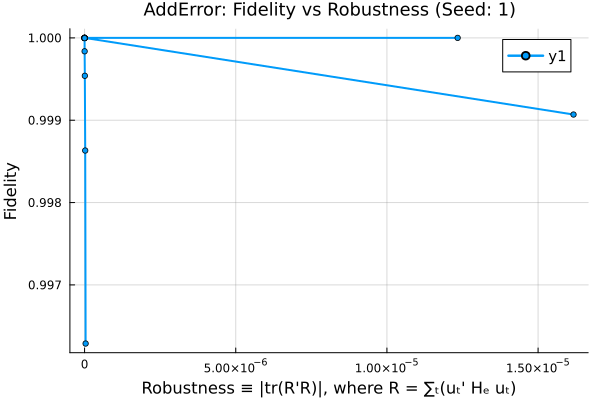

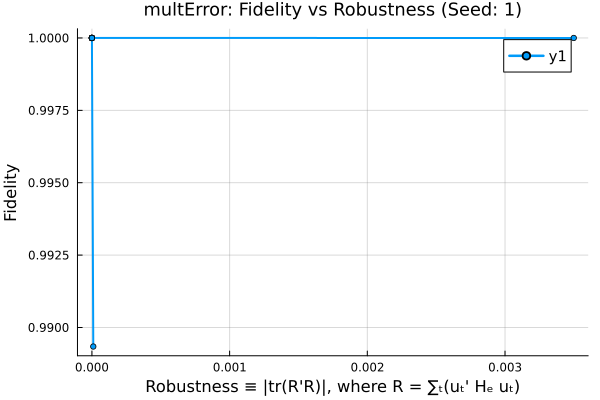

In [39]:
# using Plots
# Initialize storage for fidelities for each lambda
n_lambdas = length(sweep_rob_loss_λ)
n_seeds = length(a_guess)
templates = [add_probs, add_probs]#, both_tog_probs]
# Store fidelities for each lambda and error combination


base_fidelities = zeros(n_seeds, n_lambdas)
additive_fidelities = zeros(n_seeds, n_lambdas)
multiplicative_fidelities = zeros(n_seeds, n_lambdas)
both_fidelities = zeros(n_seeds, n_lambdas)
obj_vals = zeros(n_seeds, n_lambdas)

Hₑ_add = a -> PAULIS.X
X_drive = sys.H.H_drives[1]
Hₑ_mult = a -> a[1] * X_drive
configs = [
            (add_probs, additive_fidelities, Hₑ_add),
            (mult_probs, multiplicative_fidelities, Hₑ_mult)
            # (both_tog_probs, both_fidelities, varsys_both)
        ]
title_idx = 1
titles = ["Add", "mult"]#, "Both"]

for (probs, fidelities, Hₑ) in configs
    println("----------------!New noise model!----------------")
    # Calculate fidelities for each seed
    for seed_idx in 1:n_seeds
        # Calculate fidelities for each lambda
        for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
            
            prob = probs[seed_idx, λ_idx]
            println("\nProcessing λ = $λ")
            obj = QuantumObjectives.FirstOrderObjective(Hₑ, prob.trajectory; Q_t=λ)#prob.trajectory.Ũ⃗ᵥ1[:, end]
            Z_vec = vec(prob.trajectory)
            obj_val = obj.L(Z_vec)/λ
            obj_vals[seed_idx, λ_idx] = obj_val
            
            rob_fid = unitary_rollout_fidelity(prob.trajectory, sys)
            fidelities[seed_idx, λ_idx] = rob_fid
        end
        title_name = titles[title_idx]
        p1 = Plots.plot(xlabel="Robustness ≡ |tr(R'R)|, where R = ∑ₜ(uₜ' Hₑ uₜ)", 
                ylabel="Fidelity",
                title=title_name*"Error: Fidelity vs Robustness (Seed: $seed_idx)",
                legendfontsize=10, titlefontsize=12,
                grid=true, gridwidth=1, gridcolor=:gray, gridalpha=0.3,
                legend=:topright)

            
        Plots.plot!(p1, obj_vals[seed_idx, :], fidelities[seed_idx, :],
            marker=:circle, markersize=3, linewidth=2)


        # Display all plots
        display(p1)
    end
    title_idx += 1
end

# # Detailed results table
# println("\n=== Detailed Results Table ===")
# for seed_idx in 1:n_seeds
#     println("\nseed idx = $seed_idx:")
#     println("Weight λ | Base Fidelity | Add Fidelity | Mult Fidelity | Both")
#     println("-" ^ 40)
#     for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
#         println("$(lpad(round(λ, digits=4), 7)) | $(lpad(round(base_fidelities[seed_idx, λ_idx], digits=6), 12)) | $(lpad(round(additive_fidelities[seed_idx, λ_idx], digits=6), 12)) | $(lpad(round(multiplicative_fidelities[seed_idx, λ_idx], digits=6), 13)) | $(lpad(round(both_fidelities[seed_idx, λ_idx], digits=6), 12)) |")
#     end
# end
